In [3]:
import os

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display, HTML, clear_output

from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
TEXT_COLOR = 'white'
BG_COLOR = 'black'
plt.rcParams['axes.facecolor'] = BG_COLOR
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['text.color'] = TEXT_COLOR
plt.rcParams['axes.labelcolor'] = TEXT_COLOR
plt.rcParams['xtick.color'] = TEXT_COLOR
plt.rcParams['ytick.color'] = TEXT_COLOR

# TODO https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [4]:

# TODO :
# faire une base d'evaluation en plus de train et test
# implementer un systeme d'epoch complet avec tf.dataset
# ajouter les données non supervisées au discriminateur => extraction des feature des texte non labelisé à faire
# annulation de la loss du label parametrable (lors de l'utilisation des data non supervisé), faisable en ajoutant des boolean au discriminateur faisant office de mask
# Masking loss : https://stackoverflow.com/questions/64130293/custom-loss-function-in-keras-with-masking-array-as-input

#multi output loss https://datascience.stackexchange.com/questions/86700/custom-loss-function-with-multiple-outputs-in-tensorflow

# https://ledatascientist.com/analyse-de-sentiments-avec-camembert/
# https://ledatascientist.com/introduction-a-la-categorisation-de-textes/
# https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification
# https://lbourdois.github.io/blog/nlp/BERT/


# I. Preparation des données

## A. Features extraction

In [5]:
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
# camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
refaire_extraction = False
if(refaire_extraction):

	camembert = TFCamembertModel.from_pretrained("camembert-base")
	tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

	class CustomCamemBERT(tf.keras.Model):
		def __init__(self, camembert, tokenizer):
			super().__init__()
			self.tokenizer = tokenizer
			self.cam = camembert
			self.GAP = GlobalAveragePooling1D()
			# self.GAP = Flatten()

		def call(self, inputs):
			l = tf.reshape(tf.convert_to_tensor(()), (0, 768 * 1))
			for sentence in inputs:
				# print("\nSentence:", sentence)
				tokenized = tokenizer.tokenize(sentence)
				# print(tokenized)
				encoded = tokenizer.encode(tokenized)
				# print(encoded)
				# print(tokenizer.decode(encoded))
				encoded_sentence = tf.constant([encoded], dtype=tf.int32)
				# print("Sentence encoded:", encoded_sentence.numpy())
				x = self.cam(encoded_sentence).last_hidden_state
				# print(x.shape)
				x = x[:,0,:]
				#x = self.GAP(x)
				# x = tf.reduce_mean(x, axis=1)
				# print("x", x)
				l = tf.concat([l, x], 0)
			# print("l", l)
			return l

	# tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
	# encoded_sentence = tf.constant([tokenizer.encode(tokenizer.tokenize("J'aime le camembert !"))], dtype=tf.int32)
	# print(encoded_sentence)
	# camembert(encoded_sentence)

	NLP_model = CustomCamemBERT(camembert, tokenizer)
	NLP_model.trainable = False

	# display(model("J'aime le camembert !"))
	features = NLP_model(["J'adore le camembert", "J'aime le camembert", "J'aime pas le camembert", "Je déteste le camembert"])
	# features = NLP_model(["femme", "homme", "roi", "renne"])
	# features = features.numpy()
	# display(features)
	# features.shape
	# for i in range(len(features)):
	# 	display(np.sqrt(np.sum((features[1] - features[i]) ** 2)))

	np.sqrt(np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis = -1))
	# TODO : tester le distance de ces deux vecteurs avec 2 autre "je deteste le camenbert" et "j'adore le camenbert"

In [6]:
if(os.path.isfile('./featured.csv')):
	sup = np.genfromtxt('featured.csv', delimiter=',')
	print(np.unique(sup[:, :1], return_counts=True))
	
else:
	sup = pd.read_csv("./supervise.csv")[["text", "label_shufan"]]
	features = NLP_model(sup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = np.array([sup["label_shufan"]]).T
	sup = np.concatenate([labels, features], axis=1)
	np.savetxt('featured.csv', sup, delimiter=",")

	moresup = pd.read_csv("./newdata.csv")[["text", "Classification"]]
	mapping = {'observation':1, 'information':0, 'hors sujet':0, 'pub':0}
	moresup[["Classification"]] = moresup[["Classification"]].applymap(lambda s: mapping.get(s) if s in mapping else s)
	features = NLP_model(moresup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = moresup[["Classification"]].values
	moresup = np.concatenate([labels, features], axis=1)

	allsup = np.concatenate([sup, moresup])

if(os.path.isfile('./nonsup_features.csv')):
	nonsup = pd.read_csv("./nonsup_features.csv").values
else:
	nonsup = pd.read_csv("./nonsupervise.csv")[0:5000]
	nonsup = NLP_model(nonsup.to_numpy().reshape(-1,).tolist())
	np.savetxt('./nonsup_features.csv', nonsup, delimiter=",")



(array([0., 1.]), array([566,  71], dtype=int64))


## B. Split train / test (cf schema)

In [7]:
_, c = np.unique(sup[:, 0], return_counts=True)
nb_observations = c[1]
sup_train = np.concatenate([sup[sup[:,0] == 1][:], sup[sup[:,0] == 0][0:nb_observations]])
sup_test_surplus = sup[sup[:,0] == 0][nb_observations:]
sup_train[:,0]

def odd_distribution(data):
	A, B = data[data[:, 0] == 1], data[data[:, 0] == 0]
	C = [None]*(len(A)+len(B))
	C[::2] = A
	C[1::2] = B
	return np.array(C)

sup_train = odd_distribution(sup_train)

y_nonsup = np.ones((len(nonsup), 1))
nonsup_dataset = tf.data.Dataset.from_tensor_slices((nonsup,  y_nonsup))
# nonsup_dataset = nonsup_dataset.shuffle(buffer_size=2048).repeat(2).batch(25)
nonsup_dataset = nonsup_dataset.shuffle(buffer_size=1024).batch(25)
# for step, (x_batch_train, y_batch_train) in enumerate(nonsup_dataset):
# 	print(step, np.mean(x_batch_train), y_batch_train.shape)

sup_train[:,0]

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0.])

# II. Preparations des modèles

In [32]:
latent_dim = 100

def generate_noise(n_batch, latent_dim=100):
    return np.random.randn(latent_dim * n_batch).reshape((n_batch, latent_dim))

def generate_fake_samples(n_batch, labelN, generator):
	labels = np.repeat(labelN, n_batch)
	X_fake = generator.predict([generate_noise(n_batch, generator.inputs[0].shape[1]), labels])
	y_fake = [labels, np.repeat(0, n_batch)]
	return X_fake, y_fake

def select_real_samples(n_batch, labelN, dataset):
	dataset = dataset[dataset[:, 0] == labelN, :]
	ind = np.random.choice(len(dataset), size=n_batch, replace=False)
	labels = np.repeat(labelN, n_batch)
	X_real = np.array(dataset[ind, 1:].tolist())
	y_real =  [labels, np.repeat(1, n_batch)]
	return X_real, y_real

def train_d(discriminator, discriminator_R_only, dataset, dataset_nonsup, n_batch, force_bruit=0.001):
	# (n_batch, 768), ([label, validité])
	# X_real, y_real = select_real_samples(n_batch, 0, dataset=dataset)
	# d_real_0 = discriminator.train_on_batch(X_real, y_real)

	# X_real, y_real = select_real_samples(n_batch, 1, dataset=dataset)
	# d_real_1 = discriminator.train_on_batch(X_real, y_real)
	d_real = []
	d_fake0 = []
	d_fake1 = []
	d_nonsup_r = []

	for step, (x_batch_train, y_batch_train) in enumerate(dataset):
		# print(x_batch_train.shape, y_batch_train.shape)

		# entrainement sur données labellisée reels
		d_real.append(discriminator.train_on_batch(x_batch_train, y_batch_train))
		
		# entrainement sur données labellisée générées (0)
		X_fake, y_fake = generate_fake_samples(n_batch, 0, generator=G)
		d_fake0.append(discriminator.train_on_batch(X_fake, y_fake))
		
		# entrainement sur données labellisée générées (1)
		X_fake, y_fake = generate_fake_samples(n_batch, 1, generator=G)
		d_fake1.append(discriminator.train_on_batch(X_fake, y_fake))

	# entrainement sur données non labellisée => uniquement prediction de la réalité de la donnée
	for step, (x_batch_train, y_batch_train) in enumerate(dataset_nonsup):
		d_nonsup_r.append(discriminator_R_only.train_on_batch(x_batch_train, y_batch_train))

	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	d_real = np.mean(d_real, axis=0)
	d_fake0 = np.mean(d_fake0, axis=0)
	d_fake1 = np.mean(d_fake1, axis=0)
	d_nonsup_r = np.mean(d_nonsup_r)
	losses = np.concatenate([[d_real], [d_fake0], [d_fake1]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses, d_nonsup_r

def train_g(gan, n_batch, step, force_bruit=0.001):
	reality = np.repeat(0, n_batch) + np.random.rand(n_batch) * force_bruit # ajout de bruit
	g_loss_1 = []
	g_loss_0 = []
	return_dict = False
	for s in range(step):
		labels = np.repeat(1, n_batch) - np.random.rand(n_batch) * force_bruit # ajout de bruit
		noise = generate_noise(n_batch, latent_dim)
		g_loss_1.append(gan.train_on_batch([noise, labels], [labels, reality], return_dict=return_dict))

		labels = np.repeat(0, n_batch) + np.random.rand(n_batch) * force_bruit # ajout de bruit
		noise = generate_noise(n_batch, latent_dim)
		g_loss_0.append(gan.train_on_batch([noise, labels], [labels, reality], return_dict=return_dict))
	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	g_loss_1 = np.mean(g_loss_1, axis=0) # possibilité d'avoir l'erreur par type de label pour voir si le G performe mieux sur un label plutôt qu'un autre, ici je moyenne le cas 1 et 0
	g_loss_0 = np.mean(g_loss_0, axis=0)
	losses = np.concatenate([[g_loss_1], [g_loss_0]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses

In [17]:
tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

def accuracy(flip: bool = False): 
	""" Genere les fonctions de metriques de precision pour les modèles GAN et D """
	if flip:
		def acc(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true, 1 - y_pred)
	else:
		def acc(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true, y_pred)
	return acc

"""
Cooeficient qui determine l'importance d'une prediction plutot qu'une autre (à traiter comme un meta-parametre)
K pondere l'erreur lié à la prediction de la realité de la donnée
1 - K pondere l'erreur lié à la prediction du label
"""
K = 0.20 # TODO tester ce meta praremetre lorrs des phases d'evaluation
def reality_loss(flip: bool = False, k: float = K): 
	if flip:
		def f(y_true, y_pred): return (1 - k) * tf.keras.metrics.binary_crossentropy(y_true, 1 - y_pred)
	else:
		def f(y_true, y_pred): return (1 - k) * tf.keras.metrics.binary_crossentropy(y_true, y_pred)
	return f

def label_loss(flip: bool = False, k: float = K):
	if flip:
		def f(y_true, y_pred): return k * tf.keras.metrics.binary_crossentropy(y_true, 1 - y_pred)
	else:
		def f(y_true, y_pred): return k * tf.keras.metrics.binary_crossentropy(y_true, y_pred)
	return f

def f1_score(precision, recall):
	return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
	
# @tf.function
# def discriminator_realityloss(y_true, y_pred):
# 	return reality_loss(y_true, y_pred)
# => reality_loss(flip = false)

def APS(y_true, y_pred):
	return average_precision_score(y_true, y_pred)

def top_bottom_std(d):
	data = np.array(d)
	data_means = np.mean(data, axis=0)
	data = np.where(data_means < data, np.ma.array(data, mask=data_means < data).mean(axis=0), data)
	std_bottom = np.std(data, axis=0)

	data = d
	data_means = np.mean(data, axis=0)
	data = np.where(data_means > data, np.ma.array(data, mask=data_means > data).mean(axis=0), data)
	std_top = np.std(data, axis=0)

	return data_means, std_bottom, std_top

In [18]:
def generator(latent_dim):
	noise = Input(shape=(latent_dim,), name="noise_input", dtype=tf.float32)
	label = Input(shape=(1,), name="label_input", dtype=tf.float32) 

	a = Flatten()(Embedding(2, latent_dim, name="label_embeding")(label))
	a = Dense(64, activation="relu")(label)

	b = Dense(64, activation="relu")(noise)

	# x = Multiply(name="mult_label_noise")([noise, a])
	x = Concatenate(name="Combine_Inputs_Branches")([a, b])
	x = Dense(128, activation="relu")(x)
	# x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(256, activation="relu")(x)
	# x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(512, activation="relu")(x)
	# out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=np.mean(sup[:,1:]), stddev=np.std(sup[:,1:]), seed=None), name="Generated_Hidden_rep")(x) # initialisation pour un output "proche" des donné reel
	out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), name="Generated_Hidden_rep")(x)
	return Model([noise, label], out, name="Generator")

def discriminator():
	hidden_rep = Input(shape=(768,), dtype=tf.float32, name="Hidden_rep_Input")
	x = Dense(512, activation="relu")(hidden_rep)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(256, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	
	Rout = Dense(1, activation="sigmoid", name="Reality")(x)    
	Lout = Dense(1, activation="sigmoid", name="Label")(x)    

	return Model(hidden_rep, [Lout, Rout], name="Discriminator"), Model(hidden_rep, Rout, name="Discriminator"), Model(hidden_rep, Lout, name="Discriminator") # https://stackoverflow.com/questions/48335212/how-to-prevent-backpropagation-after-compiling-a-keras-model


In [51]:
def creation_models(competition=True, lrs=(0.0005, 0.0005), latent_dim=100):
	dlr, glr = lrs
	D, D_R_only, D_L_only = discriminator()
	D_GAN_optimizer = tf.keras.optimizers.Adam(learning_rate=dlr)
	# D.compile(loss={"Label":label_loss(flip = False), "Reality":reality_loss(flip = False)}, optimizer=D_GAN_optimizer)
	D.compile(
		loss    = { "Label": label_loss(flip = False), "Reality": reality_loss(flip = False) },
		metrics = { "Label": accuracy(flip = False),   "Reality": accuracy(flip = False)     },
		optimizer = D_GAN_optimizer
	)
	D_R_only.compile(loss=reality_loss(flip = False), optimizer=D_GAN_optimizer)
	D_L_only.compile(loss=label_loss(flip = False), optimizer=tf.keras.optimizers.Adam(learning_rate=dlr))
	D.trainable = False

	G = generator(latent_dim)
	G.compile()

	noise = Input(shape=(latent_dim,), name="GAN_input_noise")
	label = Input(shape=(1,), name="GAN_input_label")
	hidden_rep = G([noise, label])
	validity = D(hidden_rep)
	out0 = Lambda(lambda x: x, name="Label")(validity[0]) # juste pour le renomage des layers (sinon nom par defaut {Discriminator, Discriminator_1} bug tf ?)
	out1 = Lambda(lambda x: x, name="Reality")(validity[1])

	GAN = Model(inputs=[noise, label], outputs=[out0, out1], name="GAN")

	# cooperatif ou competition : 
	# GAN.compile( loss = {"Label": label_loss(flip = competition), "Reality": reality_loss(flip = True)}, optimizer = tf.keras.optimizers.Adam(learning_rate=glr))
	GAN.compile(
		loss    = { "Label": label_loss(flip = competition), "Reality": reality_loss(flip = True) },
		metrics = { "Label": accuracy(flip = competition),   "Reality": accuracy(flip = True)     },
		optimizer = tf.keras.optimizers.Adam(learning_rate=glr)
	)

	extractor = tf.keras.Model(inputs=D.inputs, outputs=D.layers[-3].output)
	extractor.trainable = False
	predictor = tf.keras.Model(inputs=extractor.output, outputs=D.output)
	predictor.trainable = False
	
	return (D, D_R_only, D_L_only, (extractor, predictor)), G, GAN

(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=True)

# Faire une prediction pour activer les metrics
n_predict = 100
reality = np.repeat(1, n_predict)
labels = np.repeat(1, n_predict)
noise = generate_noise(n_predict, latent_dim)
gx = G.predict([noise, labels])
D.evaluate(gx, [labels, reality])
# print(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
# print(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
print()
GAN.evaluate([noise, labels], [labels, reality])
# print(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
# print(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))
D_metrics = ['D_'+m for m in D.metrics_names]
G_metrics = ['G_'+m for m in GAN.metrics_names]
print()
print("D metrics   = " + str(D_metrics))
print("G metrics = " + str(G_metrics))

4/4 [==============================] - 0s 3ms/step - loss: 0.6996 - Label_loss: 0.1416 - Reality_loss: 0.5579 - Label_acc: 0.0000e+00 - Reality_acc: 0.2700

4/4 [==============================] - 1s 4ms/step - loss: 0.6868 - Label_loss: 0.1357 - Reality_loss: 0.5512 - Label_acc: 1.0000 - Reality_acc: 0.7300

D metrics   = ['D_loss', 'D_Label_loss', 'D_Reality_loss', 'D_Label_acc', 'D_Reality_acc']
G metrics = ['G_loss', 'G_Label_loss', 'G_Reality_loss', 'G_Label_acc', 'G_Reality_acc']


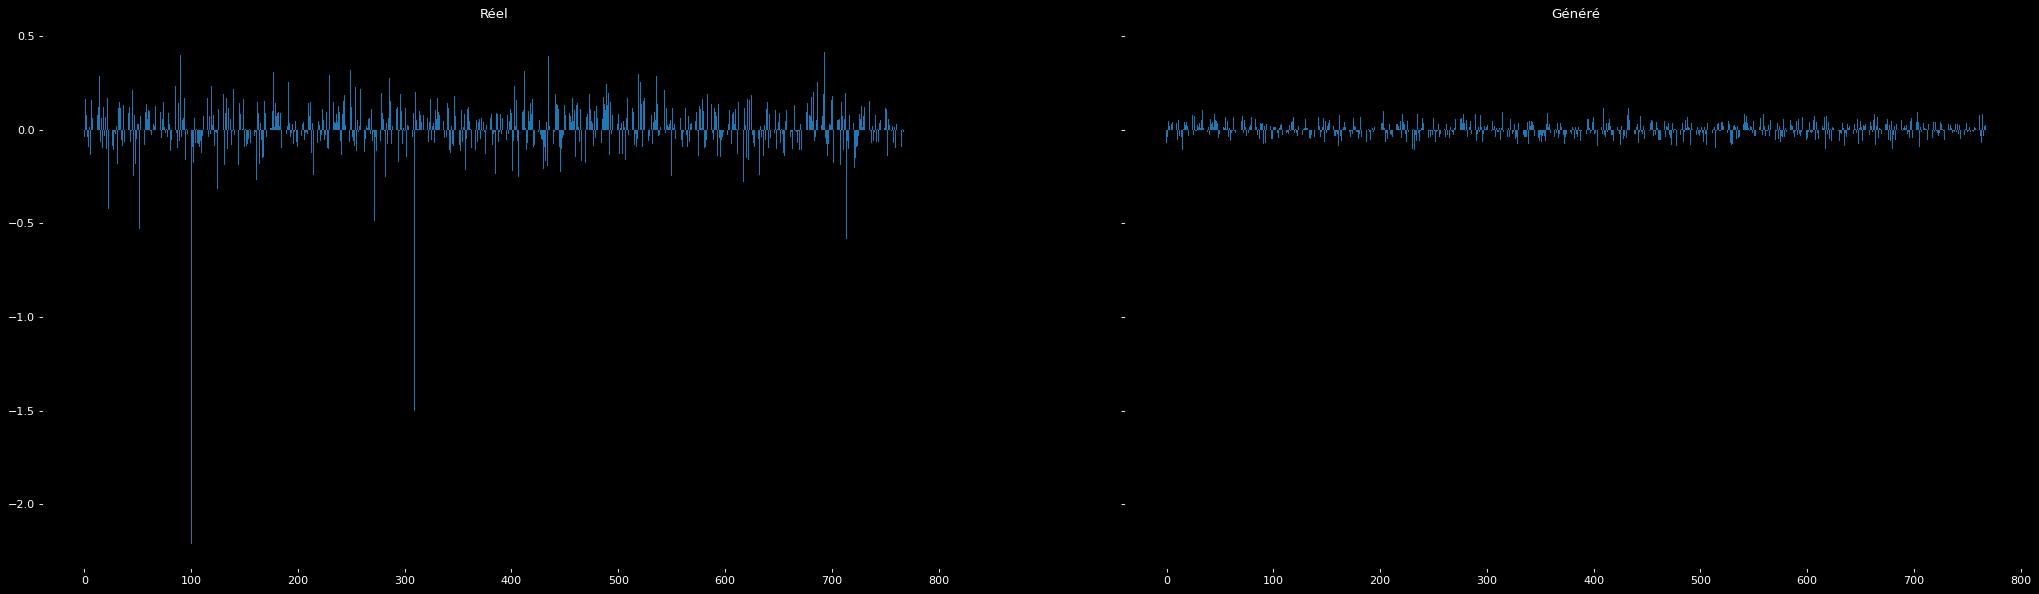

In [281]:
l = np.repeat(1, 1)
n = generate_noise(1, latent_dim)
pred_avant = G.predict([n, l])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16*2, 9), dpi=80)
axs[0].bar(range(768), sup[24,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré')
plt.show()

In [12]:
# l = np.tile([0, 1], int(244 / 2)).reshape((-1, 1))
# n = generate_noise(244, latent_dim)
# f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
# r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
# r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
# # add reality
# freality = np.repeat(0, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_reality = np.repeat(1, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_reality = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# # add label
# flabel = l.reshape((f2d.shape[0], f2d.shape[1], 1))
# train_label = sup_train[:,0].reshape((1, sup_train.shape[0], 1))
# test_label = sup_test[:,0].reshape((1, sup_test.shape[0], 1))
# # add predicction [plabel, preality]
# f2d_pred = predictor.predict(f2d[0])
# train_pred = predictor.predict(r2d_train[0])
# test_pred = predictor.predict(r2d_test[0])
# # alpha
# fa = np.repeat(1, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_a = np.repeat(0.25, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_a = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# #concatenation
# fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
# reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
# reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)

# data = np.concatenate([fakes, reels_train, reels_test], axis=1)
# data[0,0].tolist()
# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha
# plt.figure(figsize=(16, 9), dpi=80)
# MapColor = np.array(['r', 'g'])
# MapEdgecolor = np.array(['r', 'g'])
# MapMarkers = np.array(['o', 's'])
# s = 75
# es = 125 / s
# for _, m in enumerate(np.unique(data[0,:,2])):
# 	d = data[:,data[0,:,2] == m]
# 	plt.scatter(d[0,:,0], d[0,:,1], color=MapColor[d[0,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[0,:,5]).astype(int)], alpha=d[0,:,6], marker=MapMarkers[int(m)], s=s + s * d[0,:,4], linewidths=es)
# # couleur centrale = realité de la donnée (vert = reel, rouge = genere)
# # couleur de la bordure = prediction de la réalité de la donnée (vert = reel, rouge = genere)
# # carré = observation
# # rond = pas une observation

# III. Entraînement Semi-Supervisé

In [54]:
loss = tf.keras.metrics.BinaryCrossentropy(name="loss")
precision = tf.keras.metrics.Precision(thresholds=0.5, name="precision")
recall = tf.keras.metrics.Recall(thresholds=0.5, name="recall")
AUC = tf.keras.metrics.AUC(name="AUC")
metrics = [loss, precision, recall, AUC]
train_APS, test_APS = None, None

# x_train, y_train = sup_train[:, 1:], sup_train[:, 0]
# x_test, y_test = sup_test[:, 1:], sup_test[:, 0]

thresholds = 0.5



tf.config.run_functions_eagerly(False)
# tf.data.experimental.disabled_debug_mode()
training_ss_hist = []
n_Fold = 2
n_batch = 32
D_lr, G_lr = (0.0005, 0.0005)
competition = False
epochs = 20
k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	# print('\nTrain: %s | test: %s' % (train_index.shape, test_index.shape))

	(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold

	
	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus de non observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]
	
	# print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))
	# print(y_train.reshape(-1,))

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(n_batch)
	train_dataset = train_dataset.batch(n_batch)

	
	register_every = 1
	pdhist = pd.DataFrame(columns= D_metrics + ["d_R_only_loss"] + G_metrics + ["loss", "Precision", "Recall", "AUC", "APS", "val_loss", "val_Precision", "val_Recall", "val_AUC", "val_APS"])
	hist = []
	for e in range(epochs):
		d_loss, d_R_only_loss = train_d(D, D_R_only, train_dataset, nonsup_dataset, n_batch)
		g_loss = train_g(GAN, n_batch, step=len(train_dataset))
		if(e % register_every == 0):
			y_pred_score = D.predict(x_train)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_train, y_pred_score) for metric in metrics] # update
			train_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			train_APS = APS(y_train, y_pred_score)

			y_pred_score = D.predict(x_test)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_test, y_pred_score) for metric in metrics] # update
			test_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			test_APS = APS(y_test, y_pred_score)
				
			# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
			# print(f"""
			# Precision: 	{precision}
			# Recall: 	{recall}
			# f1_score: 	{f1}
			# AUC: 		{AUC}
			# Matrice de confusion:\n{confusion_matrix}
			# """)

			"""
			f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
			r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
			r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
			# add predicction [plabel, preality]
			f2d_pred = predictor.predict(f2d[0])
			train_pred = predictor.predict(r2d_train[0])
			test_pred = predictor.predict(r2d_test[0])		
			#concatenation
			fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
			reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
			reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)		
			newdata = np.concatenate([fakes, reels_train, reels_test], axis=1)
			data = np.concatenate([data, newdata], axis=0)
			"""

			# hist.append([d_loss, g_loss, precision, recall, f1, AUC, train_precision, train_recall, train_f1, train_AUC])
			hist.append([*d_loss, d_R_only_loss, *g_loss, *train_metrics, train_APS, *test_metrics, test_APS])
			pdhist = pdhist.append(pd.DataFrame([hist[-1]], columns=list(pdhist)), ignore_index=True)
			clear_output(wait=True)
			display(f"fold: {step}")
			display(pdhist.tail(10).round(2))
	# print(pdhist.to_dict('list'))
	training_ss_hist.append(pdhist.to_dict('list'))

# os.system("ffmpeg -r 1 -i ./training/e%01d.png -vcodec mpeg4 -y movie.mp4")
h = np.array(hist)


'fold: 1'

,D_loss,D_Label_loss,D_Reality_loss,D_Label_acc,D_Reality_acc,d_R_only_loss,G_loss,G_Label_loss,G_Reality_loss,G_Label_acc,...,loss,Precision,Recall,AUC,APS,val_loss,val_Precision,val_Recall,val_AUC,val_APS
10,2.68,0.15,2.53,0.59,0.17,0.03,1.02,1.01,0.01,0.0,...,0.48,0.76,0.89,0.90,0.91,0.72,0.10,0.89,0.75,0.17
11,2.63,0.14,2.50,0.61,0.17,0.03,1.80,1.79,0.01,0.0,...,0.50,0.72,0.94,0.93,0.92,0.82,0.09,0.97,0.78,0.17
12,2.66,0.14,2.52,0.61,0.17,0.03,1.65,1.56,0.09,0.0,...,0.46,0.77,0.94,0.93,0.93,0.78,0.10,0.94,0.80,0.19
13,2.63,0.14,2.49,0.55,0.17,0.03,1.44,1.39,0.06,0.0,...,0.49,0.68,0.94,0.91,0.92,0.86,0.08,0.94,0.74,0.15
14,2.65,0.14,2.51,0.60,0.17,0.03,1.17,1.10,0.07,0.0,...,0.52,0.65,0.97,0.92,0.94,1.03,0.07,0.97,0.78,0.21
15,2.62,0.13,2.48,0.60,0.17,0.03,1.40,1.37,0.04,0.0,...,0.53,0.62,1.00,0.92,0.93,1.04,0.07,0.97,0.77,0.19
16,2.61,0.14,2.47,0.58,0.17,0.03,1.29,1.04,0.25,0.0,...,0.48,0.72,0.94,0.93,0.94,0.86,0.09,0.97,0.80,0.18
17,2.62,0.14,2.48,0.57,0.17,0.03,0.81,0.80,0.01,0.0,...,0.49,0.79,0.92,0.89,0.88,0.69,0.12,0.91,0.86,0.31
18,2.63,0.14,2.49,0.58,0.17,0.03,0.72,0.57,0.15,0.0,...,0.51,0.72,0.94,0.91,0.91,0.82,0.08,0.97,0.81,0.22
19,2.60,0.14,2.47,0.60,0.17,0.03,0.47,0.46,0.01,0.0,...,0.49,0.80,0.97,0.92,0.92,0.73,0.11,0.94,0.83,0.26


20 (20,)


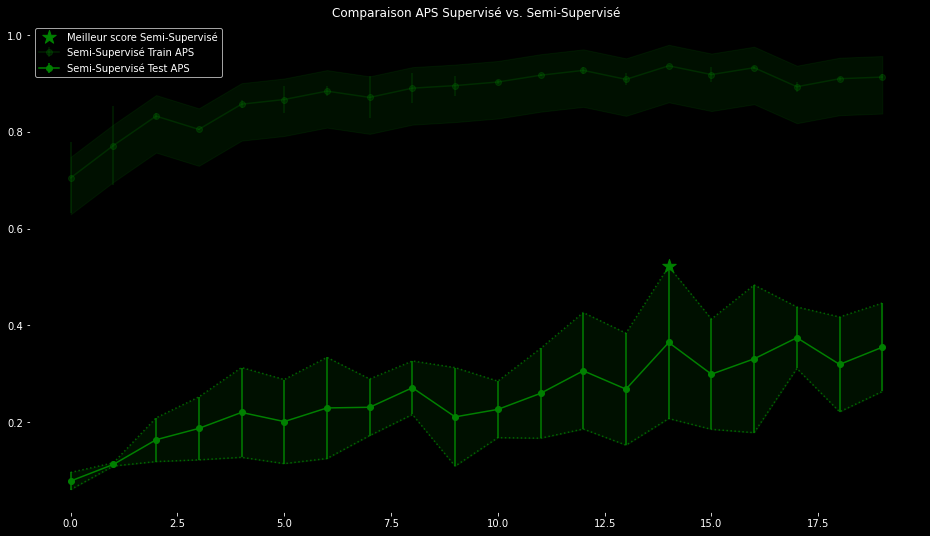

In [58]:
h_ss_train_APS = np.array([hs['APS'] for hs in training_ss_hist])
h_ss_test_APS = np.array([hs['val_APS'] for hs in training_ss_hist])

nb_epochs = np.array(h_ss_test_APS).shape[1]
print(nb_epochs, np.mean(h_ss_train_APS, axis=0).shape)
plt.figure(figsize=(16, 9))
alpha = 0.25
fmt = "-o"
plt.errorbar(range(nb_epochs), np.mean(h_ss_train_APS, axis=0), c="green", yerr=np.std(h_ss_train_APS, axis=0),label="Semi-Supervisé Train APS", alpha=alpha, fmt=fmt)
plt.errorbar(range(nb_epochs), np.mean(h_ss_test_APS, axis=0), c="green", yerr=np.std(h_ss_test_APS, axis=0),label="Semi-Supervisé Test APS", fmt=fmt)

train_mean = np.mean(h_ss_train_APS, axis=0)
train_std_top, train_std_bottom = np.std(h_ss_train_APS[h_ss_train_APS > train_mean], axis=0), np.std(h_ss_train_APS[h_ss_train_APS < train_mean], axis=0)
test_mean, test_std = np.mean(h_ss_test_APS, axis=0), np.std(h_ss_test_APS, axis=0)
plt.fill_between(range(nb_epochs), train_mean + train_std_top, train_mean - train_std_bottom, color="green", alpha=alpha/2)
plt.fill_between(range(nb_epochs), test_mean-test_std, test_mean+test_std, color="green", alpha=alpha/2)
# plt.plot(np.array(h_ss_test_APS).T, color="green", ls=":", alpha=alpha) # Tout
plt.plot(np.max(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # min
plt.plot(np.min(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # max

max_ss, e_ss = np.max(np.max(h_ss_test_APS, axis=0)), np.argmax(np.max(h_ss_test_APS, axis=0))
plt.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c='green', s=200)
plt.title("Comparaison APS Supervisé vs. Semi-Supervisé")
plt.legend()
# plt.ylim([0.85, 0.94])
plt.show()


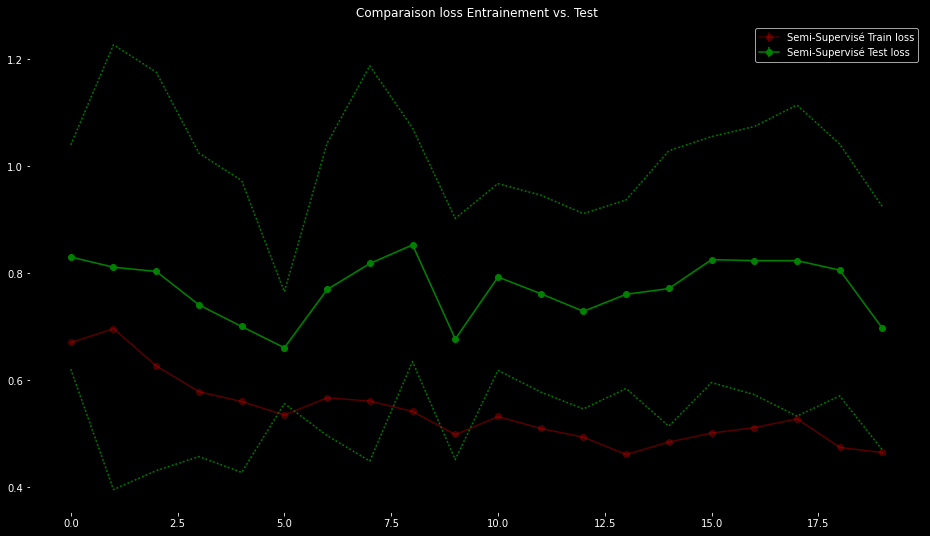

In [284]:
train_color, test_color = "red", "green"
metric = 'loss'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

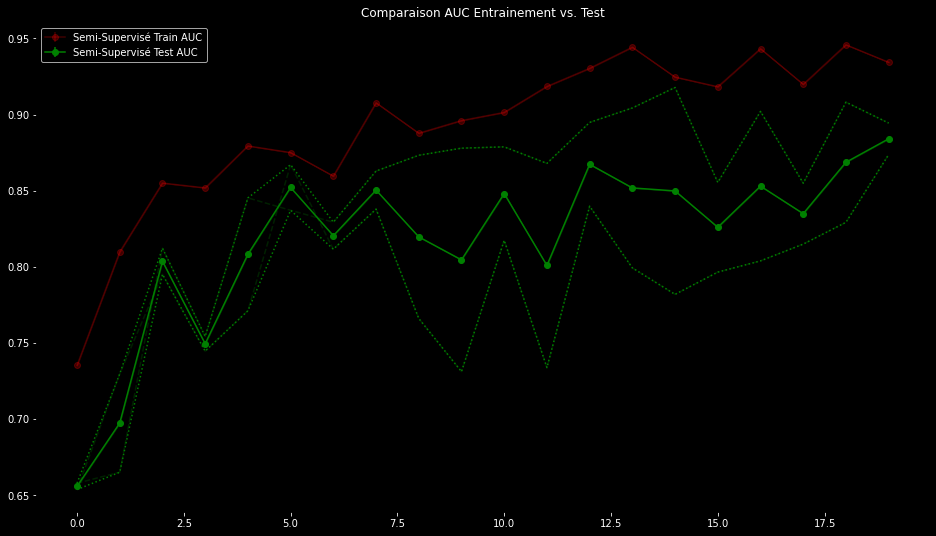

In [285]:
train_color, test_color = "red", "green"
metric = 'AUC'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

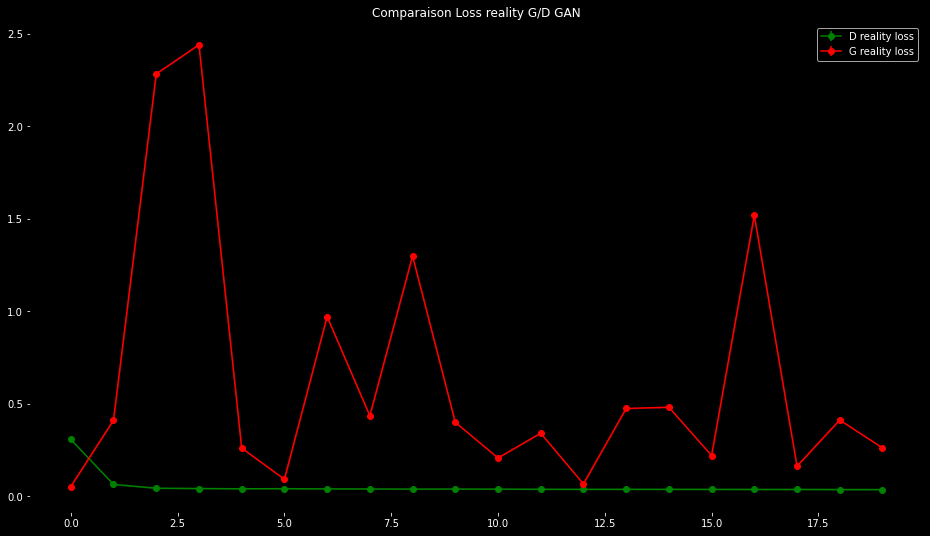

In [286]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_reality_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_reality_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D reality loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G reality loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss reality G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

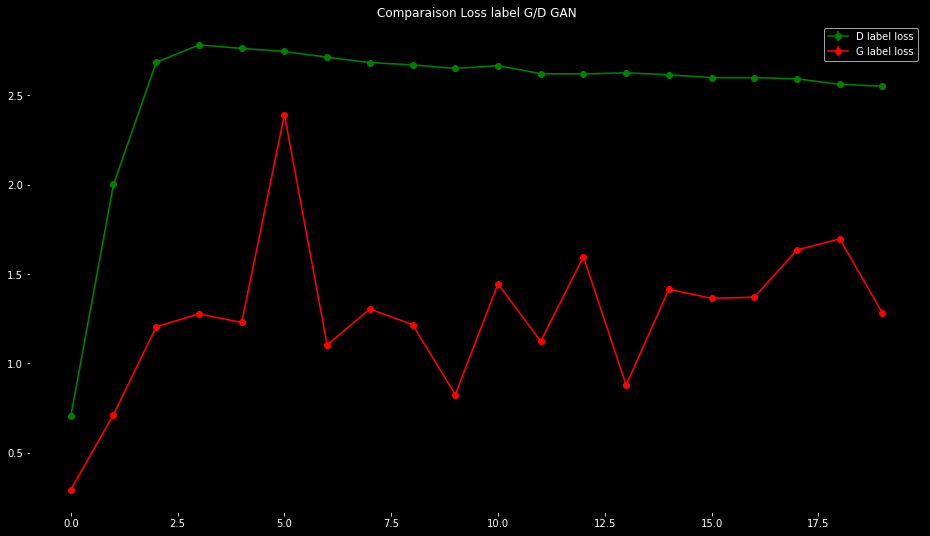

In [287]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_label_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_label_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D label loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G label loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss label G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

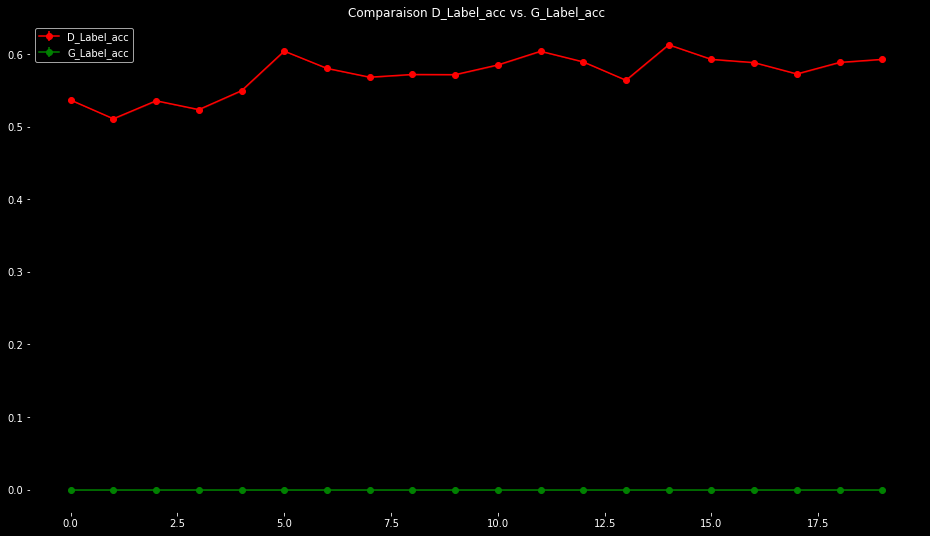

In [63]:
l1_name, l1_color = "D_Label_acc", "red"
l2_name, l2_color = "G_Label_acc", "green"

l1 = np.array([hs[l1_name] for hs in training_ss_hist])
l2 = np.array([hs[l2_name] for hs in training_ss_hist])

l1_mean, l1_bottom_std, l1_top_std = top_bottom_std(l1)
l2_mean, l2_bottom_std, l2_top_std = top_bottom_std(l2)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(l1_mean)), l1_mean, c=l1_color, yerr=[l1_bottom_std, l1_top_std], label=l1_name, fmt=fmt)
plt.errorbar(range(len(l2_mean)), l2_mean, c=l2_color, yerr=[l2_bottom_std, l2_top_std], label=l2_name, fmt=fmt)

plt.fill_between(range(len(l1_mean)), l1_mean-l1_bottom_std, l1_mean+l1_top_std, color=l1_color, alpha=alpha)
plt.fill_between(range(len(l2_mean)), l2_mean-l2_bottom_std, l2_mean+l2_top_std, color=l2_color, alpha=alpha)

plt.title(f"Comparaison {l1_name} vs. {l2_name}")
plt.legend()

plt.show()

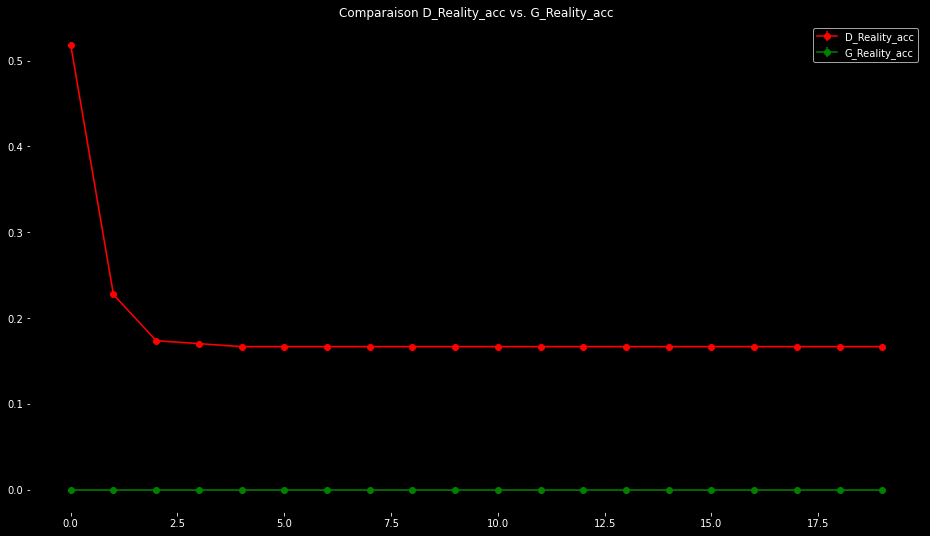

In [64]:
l1_name, l1_color = "D_Reality_acc", "red"
l2_name, l2_color = "G_Reality_acc", "green"

l1 = np.array([hs[l1_name] for hs in training_ss_hist])
l2 = np.array([hs[l2_name] for hs in training_ss_hist])

l1_mean, l1_bottom_std, l1_top_std = top_bottom_std(l1)
l2_mean, l2_bottom_std, l2_top_std = top_bottom_std(l2)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(l1_mean)), l1_mean, c=l1_color, yerr=[l1_bottom_std, l1_top_std], label=l1_name, fmt=fmt)
plt.errorbar(range(len(l2_mean)), l2_mean, c=l2_color, yerr=[l2_bottom_std, l2_top_std], label=l2_name, fmt=fmt)

plt.fill_between(range(len(l1_mean)), l1_mean-l1_bottom_std, l1_mean+l1_top_std, color=l1_color, alpha=alpha)
plt.fill_between(range(len(l2_mean)), l2_mean-l2_bottom_std, l2_mean+l2_top_std, color=l2_color, alpha=alpha)

plt.title(f"Comparaison {l1_name} vs. {l2_name}")
plt.legend()

plt.show()

In [59]:
n_predict = 1000
reality = np.repeat(1, n_predict)
labels = np.repeat(1, n_predict)
noise = generate_noise(n_predict, latent_dim)
gx = G.predict([noise, labels])
D.evaluate(gx, [labels, reality])
print(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
print(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
print()
GAN.evaluate([noise, labels], [labels, reality])
print(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
print(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))

32/32 [==============================] - 0s 2ms/step - loss: 0.1505 - Label_loss: 0.1486 - Reality_loss: 0.0019 - Label_acc: 0.4010 - Reality_acc: 1.0000
(array([0., 1.], dtype=float32), array([599, 401], dtype=int64))
(array([1.], dtype=float32), array([1000], dtype=int64))

32/32 [==============================] - 1s 4ms/step - loss: 5.2315 - Label_loss: 0.1486 - Reality_loss: 5.0829 - Label_acc: 0.4010 - Reality_acc: 0.0000e+00
(array([0., 1.], dtype=float32), array([599, 401], dtype=int64))
(array([1.], dtype=float32), array([1000], dtype=int64))


In [19]:
# h = np.array(hist)

# def plot_metrics(metrics, data=pdhist, labels=None):
# 	labels = metrics if labels is None else labels
# 	fig, ax = plt.subplots(figsize=(16, 9))
# 	for m, l in zip(metrics, labels):
# 		ax.plot(data[m], label=l)
# 	ax.legend()
# 	return fig, ax


# fig, ax = plot_metrics(["loss", "val_loss"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["AUC", "val_AUC"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["APS", "val_APS"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["D_loss", "G_loss"], data=pdhist)
# fig.show()


# alpha = 0.25
# plt.figure(figsize=(16, 9))
# plt.plot(pdhist[["Precision"]], label="Test Precision")
# plt.plot(pdhist[["Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["Precision"]].values, pdhist[["Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")

# plt.plot(pdhist[["val_Precision"]], label="Test Precision")
# plt.plot(pdhist[["val_Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["val_Precision"]].values, pdhist[["val_Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")
# plt.legend()
# plt.show()

In [20]:
# thresholds = 0.5 # limite pour l'arrondissement

# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_score = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_score > thresholds, 1, 0)

# print(np.unique(y_true, return_counts=True))
# print(np.unique(y_pred, return_counts=True))
# """
# Matrice de confusion  | Pred 0 | Pred 1 | Total
# 			Réalité 0 |   VN   |   FP   | de non observation dans la base
# 			Réalité 1 |   FN   |   VP   | d'observation dans la base
# """
# # https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# # Precision
# # = VP / (VP + FP)
# # = VP / P
# # = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# # 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# # Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# # f1 = moyenne harmonique de Precision et Recall

# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Precision: 	{precision}
# Recall: 	{recall}
# f1_score: 	{f1}
# AUC: 		{AUC}
# Matrice de confusion:\n{confusion_matrix}
# """)

# # le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# # si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# # Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# # exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# # on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# # L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)

In [21]:
# from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# plt.figure(figsize=(9, 9))
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--", label="")
# plt.title('ROC curve')
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(0,)
# plt.ylim(0,)
# plt.show()

In [22]:
# # https://youtu.be/iCZJfO-7C5Q?t=656
# plt.figure(constrained_layout=True, figsize=(16, 9))
# x = (tpr + fpr) / 2 ** (0.5)
# y = (tpr - fpr) / 2 ** (0.5)
# plt.plot(x, y)
# plt.plot([0, max(x)], [0, 0], ls="--", label="random prediction")
# plt.title('ROC curve rotation à Pi/4')
# plt.xlabel('(TPR + FPR) / sqrt(2)')
# plt.ylabel('(TPR - FPR) / sqrt(2)')
# best_t = t[np.argmax(y)]
# # print(max(y), np.argmax(y), t, best_t)
# plt.scatter(x[np.argmax(y)], np.max(y), label=best_t, marker='*', c='red', s=200)
# plt.legend()
# plt.show()
# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# t[np.argmax(tpr - fpr)], best_t

In [23]:
# thresholds = 0.5
# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_scrore = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}%
# Recall: 	{recall*100:.2f}%
# f1_score: 	{f1*100:.2f}%
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# lp, lr, lf = precision, recall, f1

# thresholds = best_t
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}% ({(precision - lp)*100:+.2f}%)
# Recall: 	{recall*100:.2f}% ({(recall - lr)*100:+.2f}%)
# f1_score: 	{f1*100:.2f}% ({(f1 - lf)*100:+.2f}%)
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# Visualisation de l'espace de decision pendant l'entraînement semi-supervisé

In [24]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1., 1.])
# 	# ax1.set_ylim([-1., 1.])
# 	for _, m in enumerate(np.unique(data[i,:,2])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,5]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,4], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

In [25]:
# with open('result_stable.html', 'w') as f:
# 	print("save...")
# 	f.write(out.data)

In [26]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	ax1.set_xlim([-1.1, 1.1])
# 	ax1.set_ylim([-1.1, 1.1])
# 	for _, m in enumerate(np.unique(data[i,:,3])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,5], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# # with open('result2.html', 'w') as f:
# # 	print("save...")
# # 	f.write(out.data)

# out

In [27]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha

# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1.1, 1.1])
# 	# ax1.set_ylim([-1.1, 1.1])
# 	d = data[:,data[i,:,3] == 1]
# 	ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6],s=s, linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

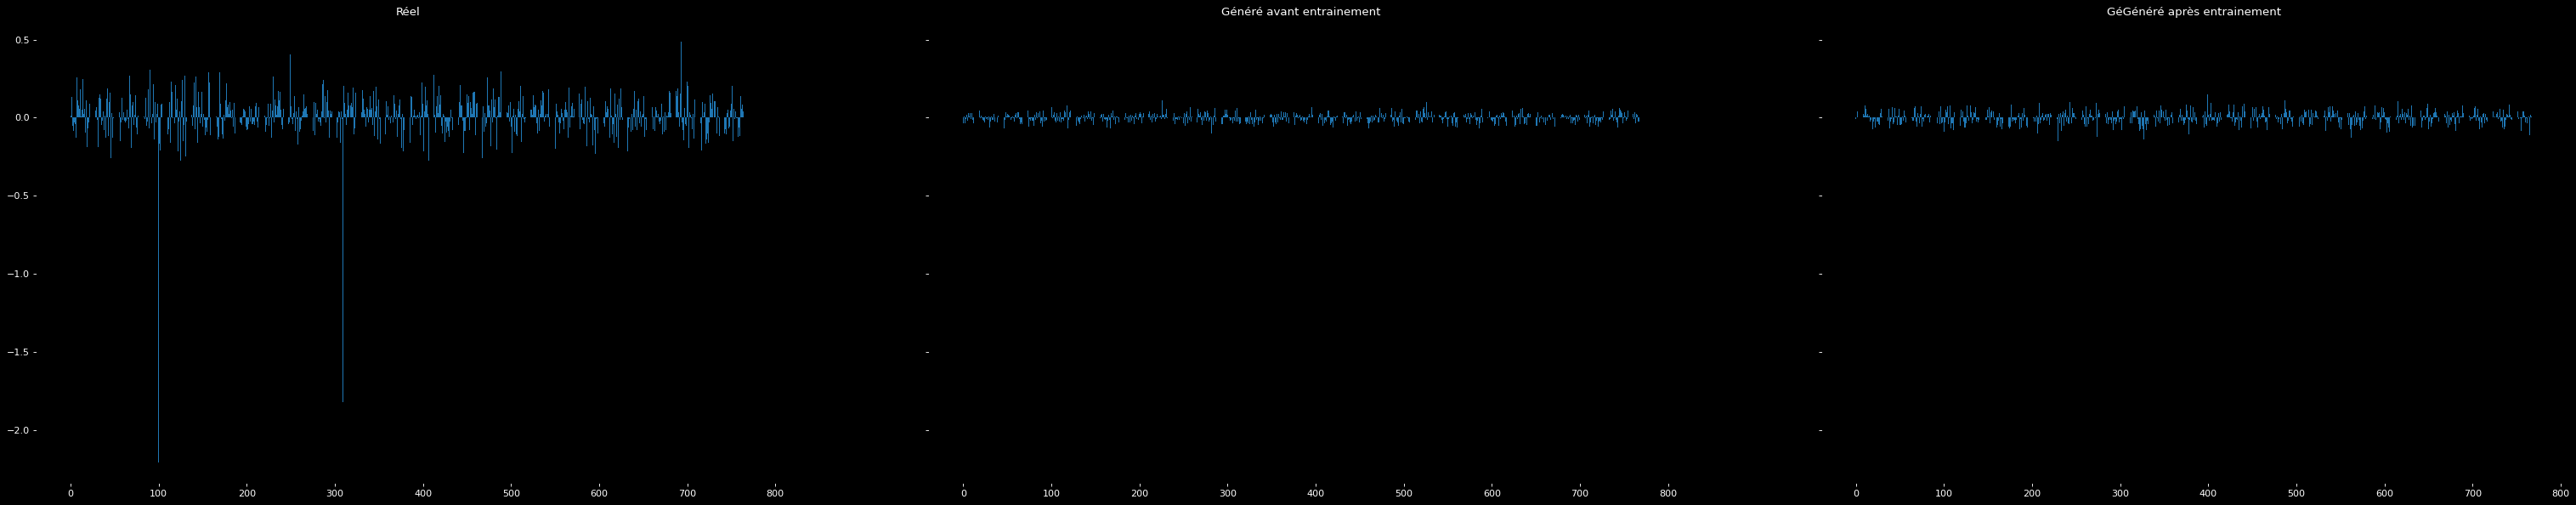

In [164]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16*3, 9), dpi=80)
pred_apres = G.predict([n, l])
axs[0].bar(range(768), sup[20,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré avant entrainement')
axs[2].bar(range(768), pred_apres[0])
axs[2].set(title='GéGénéré après entrainement')
plt.show()

In [29]:
# l = np.repeat(1, 100).reshape((-1, 1))
# n = generate_noise(100, latent_dim)
# w = 16 * 2
# h = 9
# dpi = 100
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# pred_apres = G.predict([n, l])

# axs[0].bar(range(768), np.mean(sup[:,1:], axis=0))
# axs[0].set(title='Moyenne par composants des vecteurs réels')
# axs[1].bar(range(768), np.mean(pred_apres, axis=0))
# axs[1].set(title='Moyenne par composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.std(sup[:,1:], axis=0))
# axs[0].set(title='Ecart type des vecteurs réels')
# axs[1].bar(range(768), np.std(pred_apres, axis=0))
# axs[1].set(title='Ecart type des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.max(sup[:,1:], axis=0))
# axs[0].set(title='Max des composants des vecteurs réels')
# axs[1].bar(range(768), np.max(pred_apres, axis=0))
# axs[1].set(title='Max des composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.min(sup[:,1:], axis=0))
# axs[0].set(title='Min descomposants des vecteur réels')
# axs[1].bar(range(768), np.min(pred_apres, axis=0))
# axs[1].set(title='Min descomposants des vecteurs généré après entrainement')
# plt.show()

# Partie SUPERVISE

## Entraînement

In [90]:
from tensorflow.keras.metrics import *

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

verbose = 1

# n_Fold = 4
# n_batch = 8
# D_lr, G_lr = (0.001, 0.001)
# epochs = 50

print(f"""
n_Fold 	=   {n_Fold}
n_batch =   {n_batch}
lr      =   {D_lr}
epochs 	=   {epochs}
""")

k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
hist_supervise = []
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	print(step)

	(_, _, D_L_only, _), _, _ = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold
	D_L_only.trainable = True
	
	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus d'observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	train_dataset = train_dataset.shuffle(buffer_size=1024).batch(n_batch)

	validation_batch_size = y_test.shape[0]
	
	D_L_only.compile(loss="bce", metrics=[Precision(class_id=0, name='Precision'), Recall(class_id=0, name='Recall'), AUC(name="AUC"), APS], optimizer=tf.keras.optimizers.Adam(learning_rate=D_lr))
	history_s = D_L_only.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=epochs, batch_size=n_batch, verbose=verbose, shuffle=False, validation_batch_size=validation_batch_size)
	hist_supervise.append(history_s.history)
print("done.")


n_Fold 	= 	4
n_batch =	32
lr 		=	0.0005
epochs 	=	40

0
Epoch 1/40
4/4 [==============================] - 1s 141ms/step - loss: 0.7820 - Precision: 0.6071 - Recall: 0.6415 - AUC: 0.5947 - APS: 0.5763 - val_loss: 0.6458 - val_Precision: 0.1707 - val_Recall: 0.3889 - val_AUC: 0.8033 - val_APS: 0.1450
Epoch 2/40
4/4 [==============================] - 0s 117ms/step - loss: 0.4418 - Precision: 0.7857 - Recall: 0.8302 - AUC: 0.8727 - APS: 0.8805 - val_loss: 0.6210 - val_Precision: 0.3750 - val_Recall: 0.3333 - val_AUC: 0.8507 - val_APS: 0.2377
Epoch 3/40
4/4 [==============================] - 0s 120ms/step - loss: 0.3881 - Precision: 0.8364 - Recall: 0.8679 - AUC: 0.9114 - APS: 0.9375 - val_loss: 0.5958 - val_Precision: 0.4444 - val_Recall: 0.2222 - val_AUC: 0.8996 - val_APS: 0.2489
Epoch 4/40
4/4 [==============================] - 0s 110ms/step - loss: 0.4005 - Precision: 0.7895 - Recall: 0.8491 - AUC: 0.9012 - APS: 0.9177 - val_loss: 0.5687 - val_Precision: 0.4000 - val_Recall: 0.1111 - v

In [52]:
def plot_resume(metric, alpha=0.25, errorbar=True, fill_between=True, display_train=True, plot_max=True):
	s_color, ss_color = "red", "green"
	
	h_s_train = [hs[metric] for hs in hist_supervise]
	h_s_test = [hs['val_'+metric] for hs in hist_supervise]

	h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
	h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

	train_s_mean, train_s_bottom_std, train_s_top_std = top_bottom_std(h_s_train)
	test_s_mean, test_s_bottom_std, test_s_top_std = top_bottom_std(h_s_test)

	train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
	test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

	plt.figure(figsize=(16*2, 9*1.75), dpi=120)
	fmt = "-o"

	if(errorbar):
		if(display_train):
			plt.errorbar(range(len(train_s_mean)), train_s_mean, c=s_color, yerr=[train_s_bottom_std, train_s_top_std],label="Supervisé Train"+metric, alpha=alpha, fmt=fmt)
			plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=ss_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train"+metric, alpha=alpha, fmt=fmt)
		
		plt.errorbar(range(len(test_s_mean)), test_s_mean, c=s_color, yerr=[test_s_bottom_std, test_s_top_std],label="Supervisé Test"+metric, fmt=fmt)
		plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=ss_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test"+metric, fmt=fmt)
	
	if(fill_between):
		if(display_train):
			plt.fill_between(range(len(train_s_mean)), train_s_mean-train_s_bottom_std, train_s_mean+train_s_top_std, color=s_color, alpha=alpha/2)
			plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=ss_color, alpha=alpha/2)
		plt.fill_between(range(len(test_s_mean)), test_s_mean-test_s_bottom_std, test_s_mean+test_s_top_std, color=s_color, alpha=alpha/2)
		plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=ss_color, alpha=alpha/2)

	print('='*150)
	if(plot_max):
		# plt.plot(np.array(h_s_test).T, color=s_color, ls=":", alpha=alpha)
		plt.plot(np.max(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)
		plt.plot(np.min(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)

		# plt.plot(np.array(h_ss_test).T, color=s_color, ls=":", alpha=alpha)
		plt.plot(np.max(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)
		plt.plot(np.min(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)

		max_ss, e_ss = np.max(h_ss_test), np.argmax(np.max(h_ss_test, axis=0))
		max_s, e_s = np.max(h_s_test), np.argmax(np.max(h_s_test, axis=0))
		plt.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c=ss_color, s=200)
		plt.scatter(e_s, max_s, label="Meilleur score Supervisé", marker='*', c=s_color, s=200)

		print(f"""
		Résumé de la métrique {metric} :
		Max {metric} Semi-Supervisé: {round(max_ss, 3)} (epoch: {e_ss})
		Max {metric} Supervisé:      {round(max_s, 3)} (epoch: {e_s})

		Semi-Supervisé: {(max_ss-max_s)*100:+.2f}%
		""")
	
	plt.title("Comparaison " + metric + " Supervisé vs. Semi-Supervisé")
	plt.legend()
	# plt.ylim([0.85, 0.94])

	plt.show()
	# print('='*75)


		Résumé de la métrique APS :
		Max APS Semi-Supervisé: 0.543 (epoch: 36)
		Max APS Supervisé:      0.486 (epoch: 31)

		Semi-Supervisé: +5.69%
		


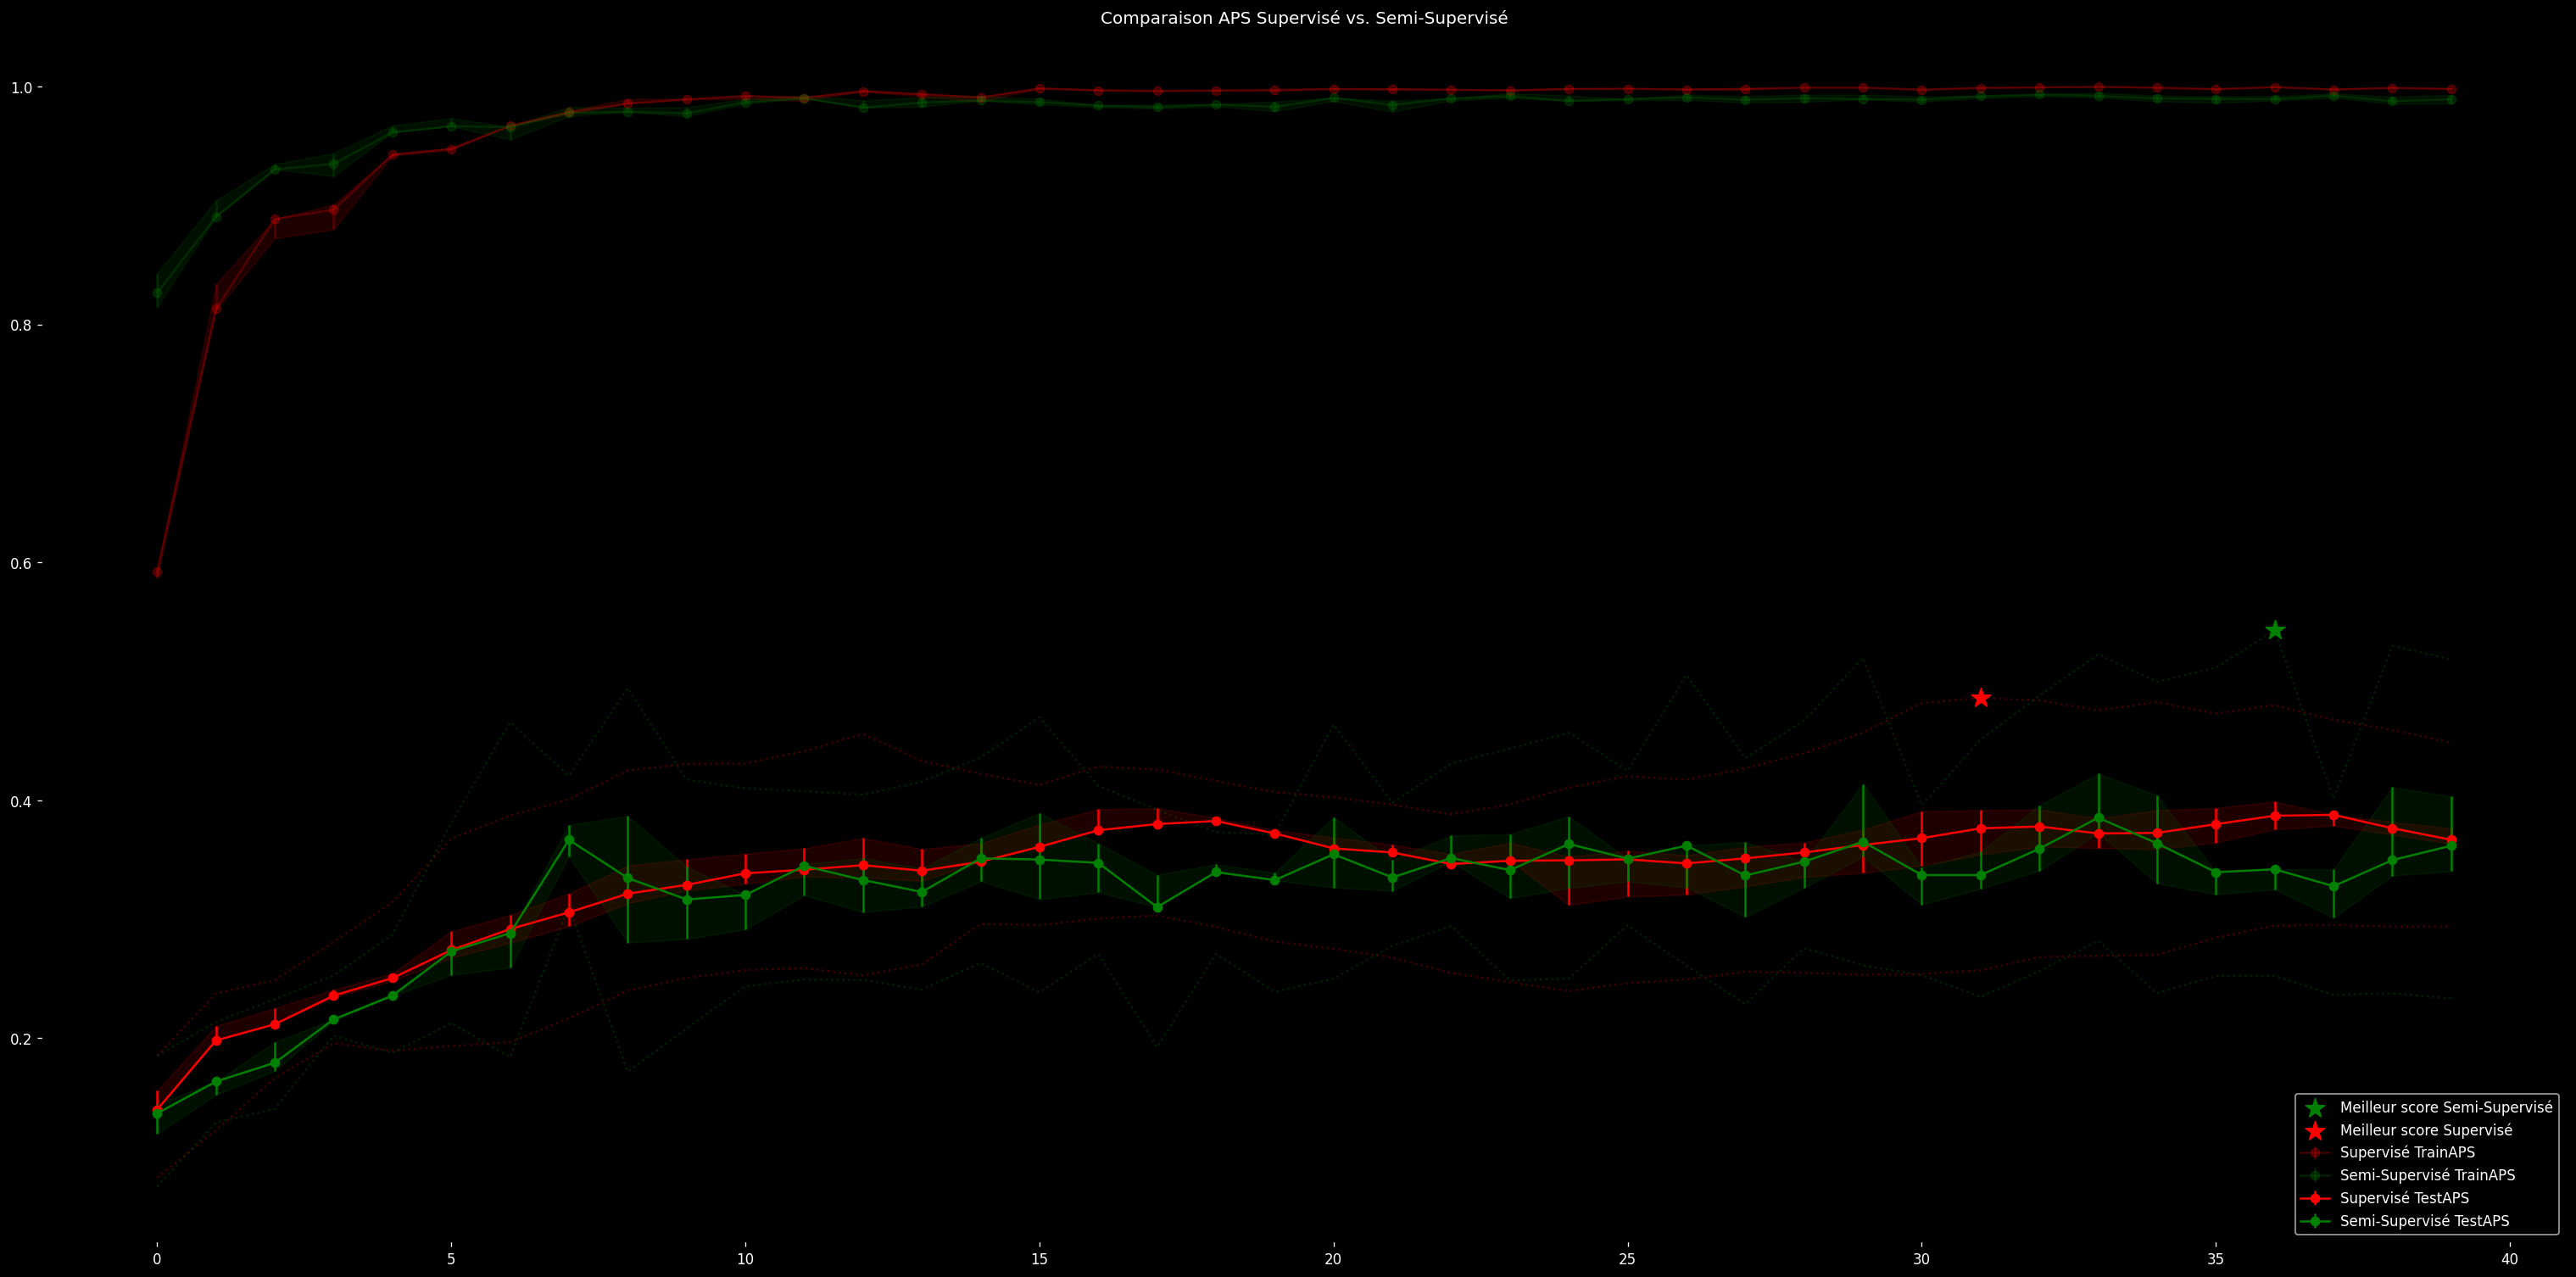


		Résumé de la métrique AUC :
		Max AUC Semi-Supervisé: 0.974 (epoch: 33)
		Max AUC Supervisé:      0.966 (epoch: 32)

		Semi-Supervisé: +0.85%
		


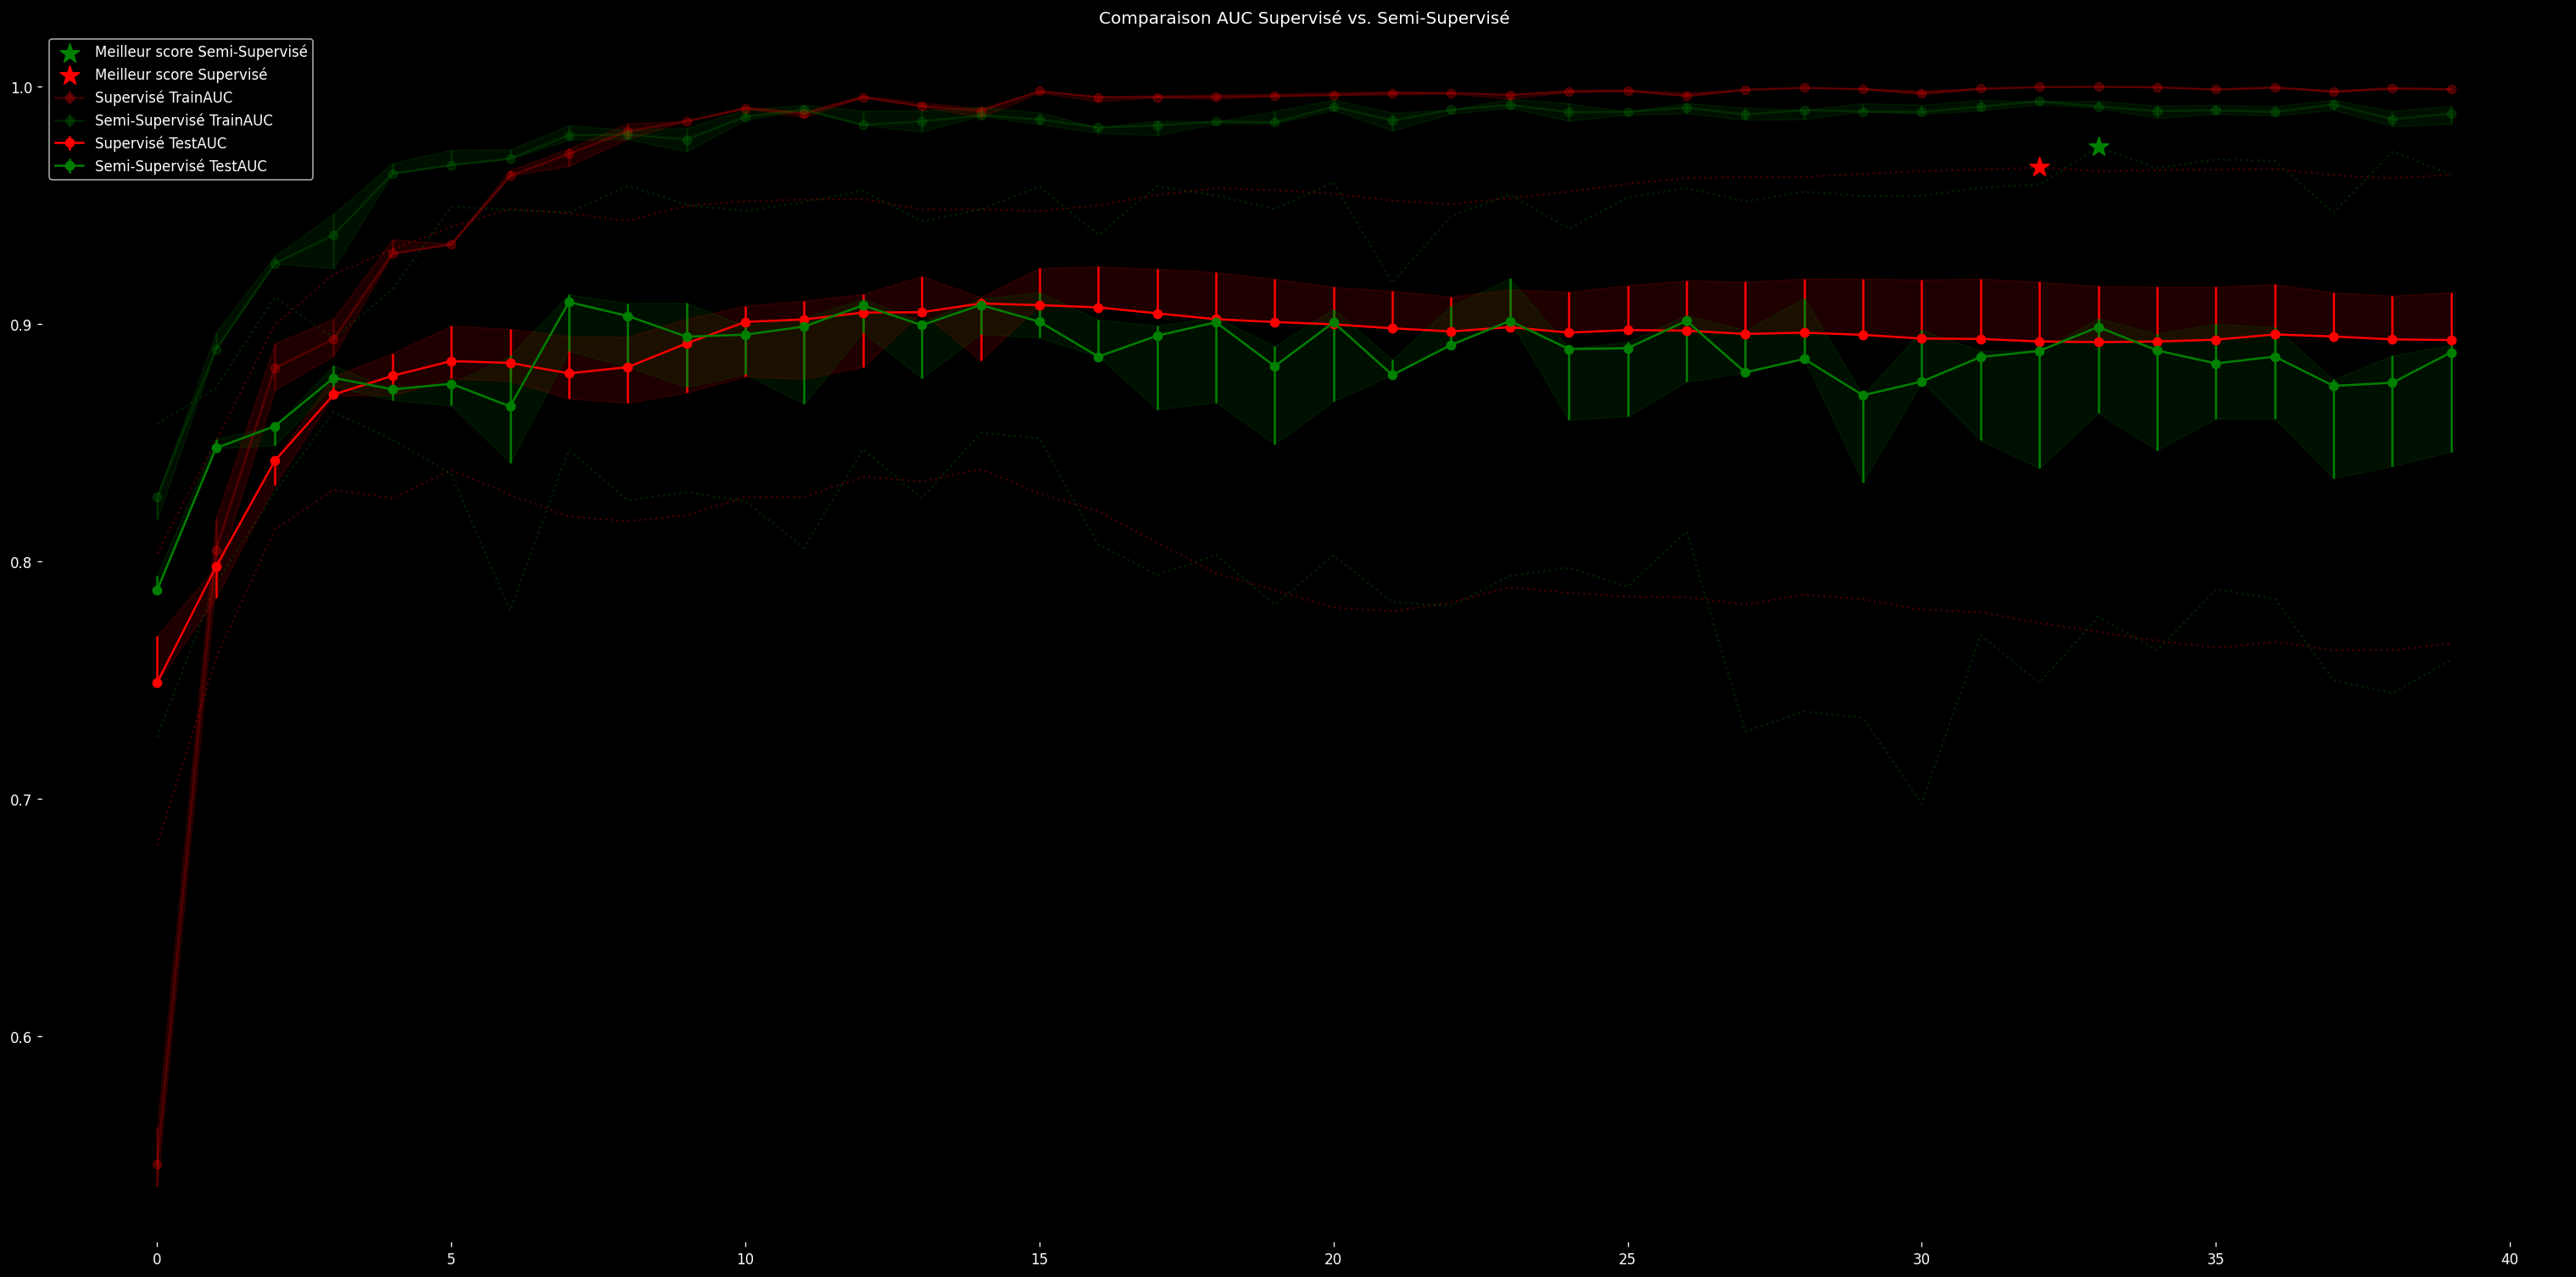


		Résumé de la métrique Precision :
		Max Precision Semi-Supervisé: 0.389 (epoch: 25)
		Max Precision Supervisé:      0.556 (epoch: 22)

		Semi-Supervisé: -16.67%
		


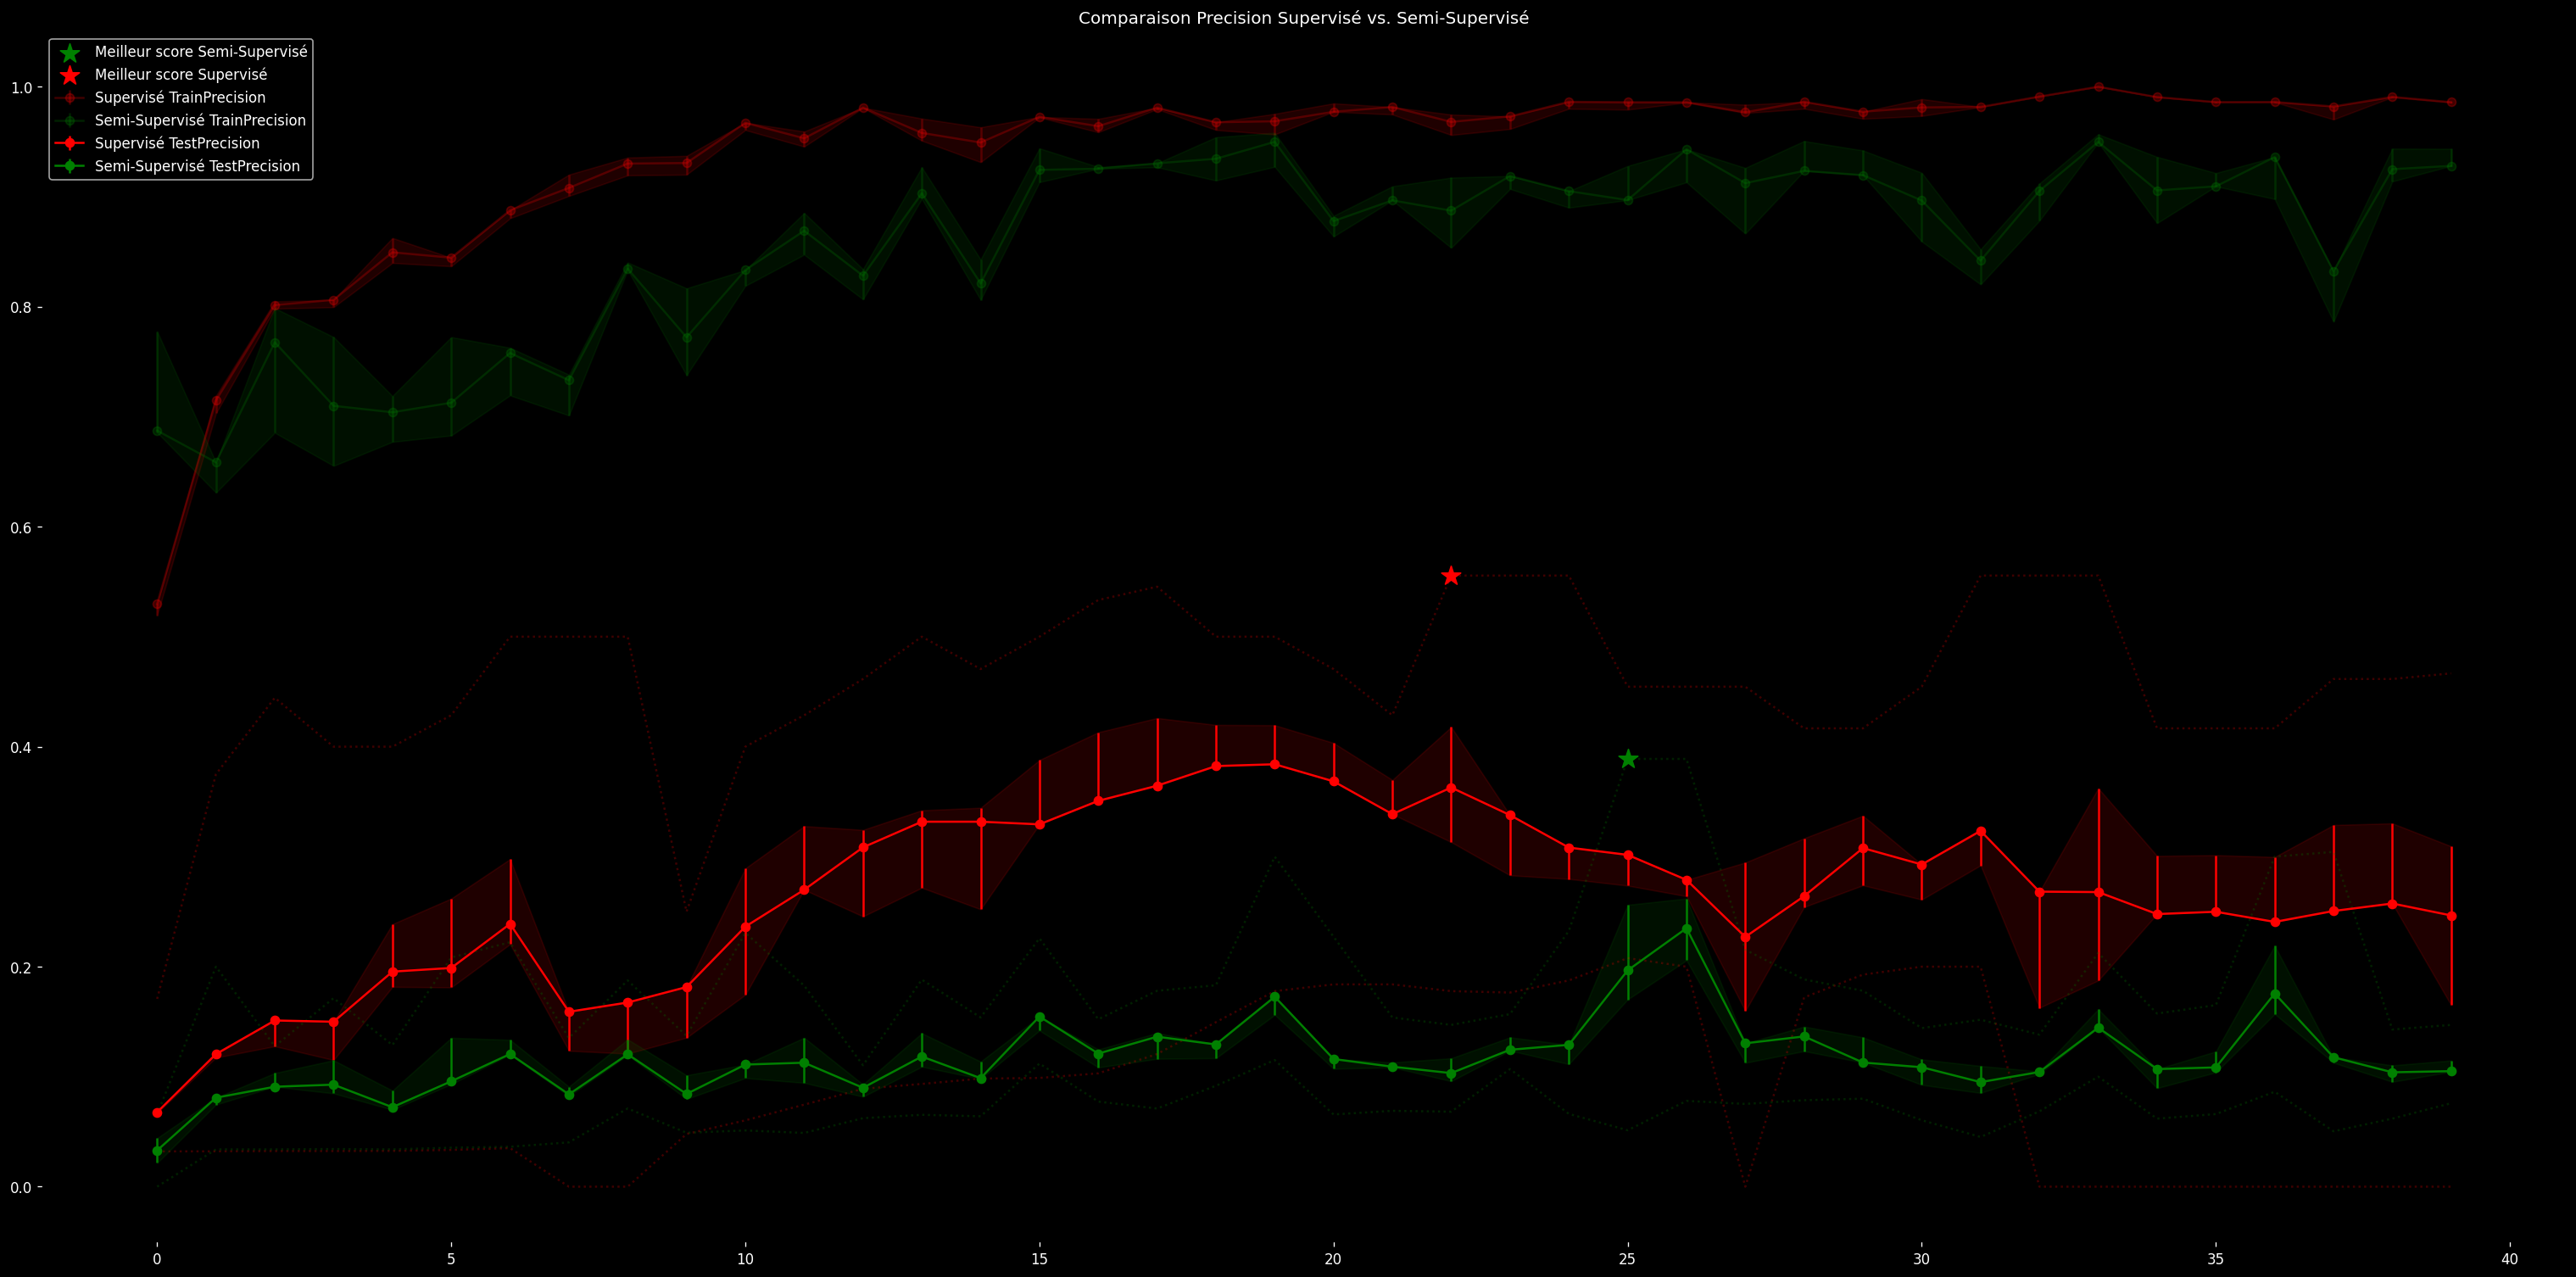


		Résumé de la métrique Recall :
		Max Recall Semi-Supervisé: 1.0 (epoch: 0)
		Max Recall Supervisé:      1.0 (epoch: 0)

		Semi-Supervisé: +0.00%
		


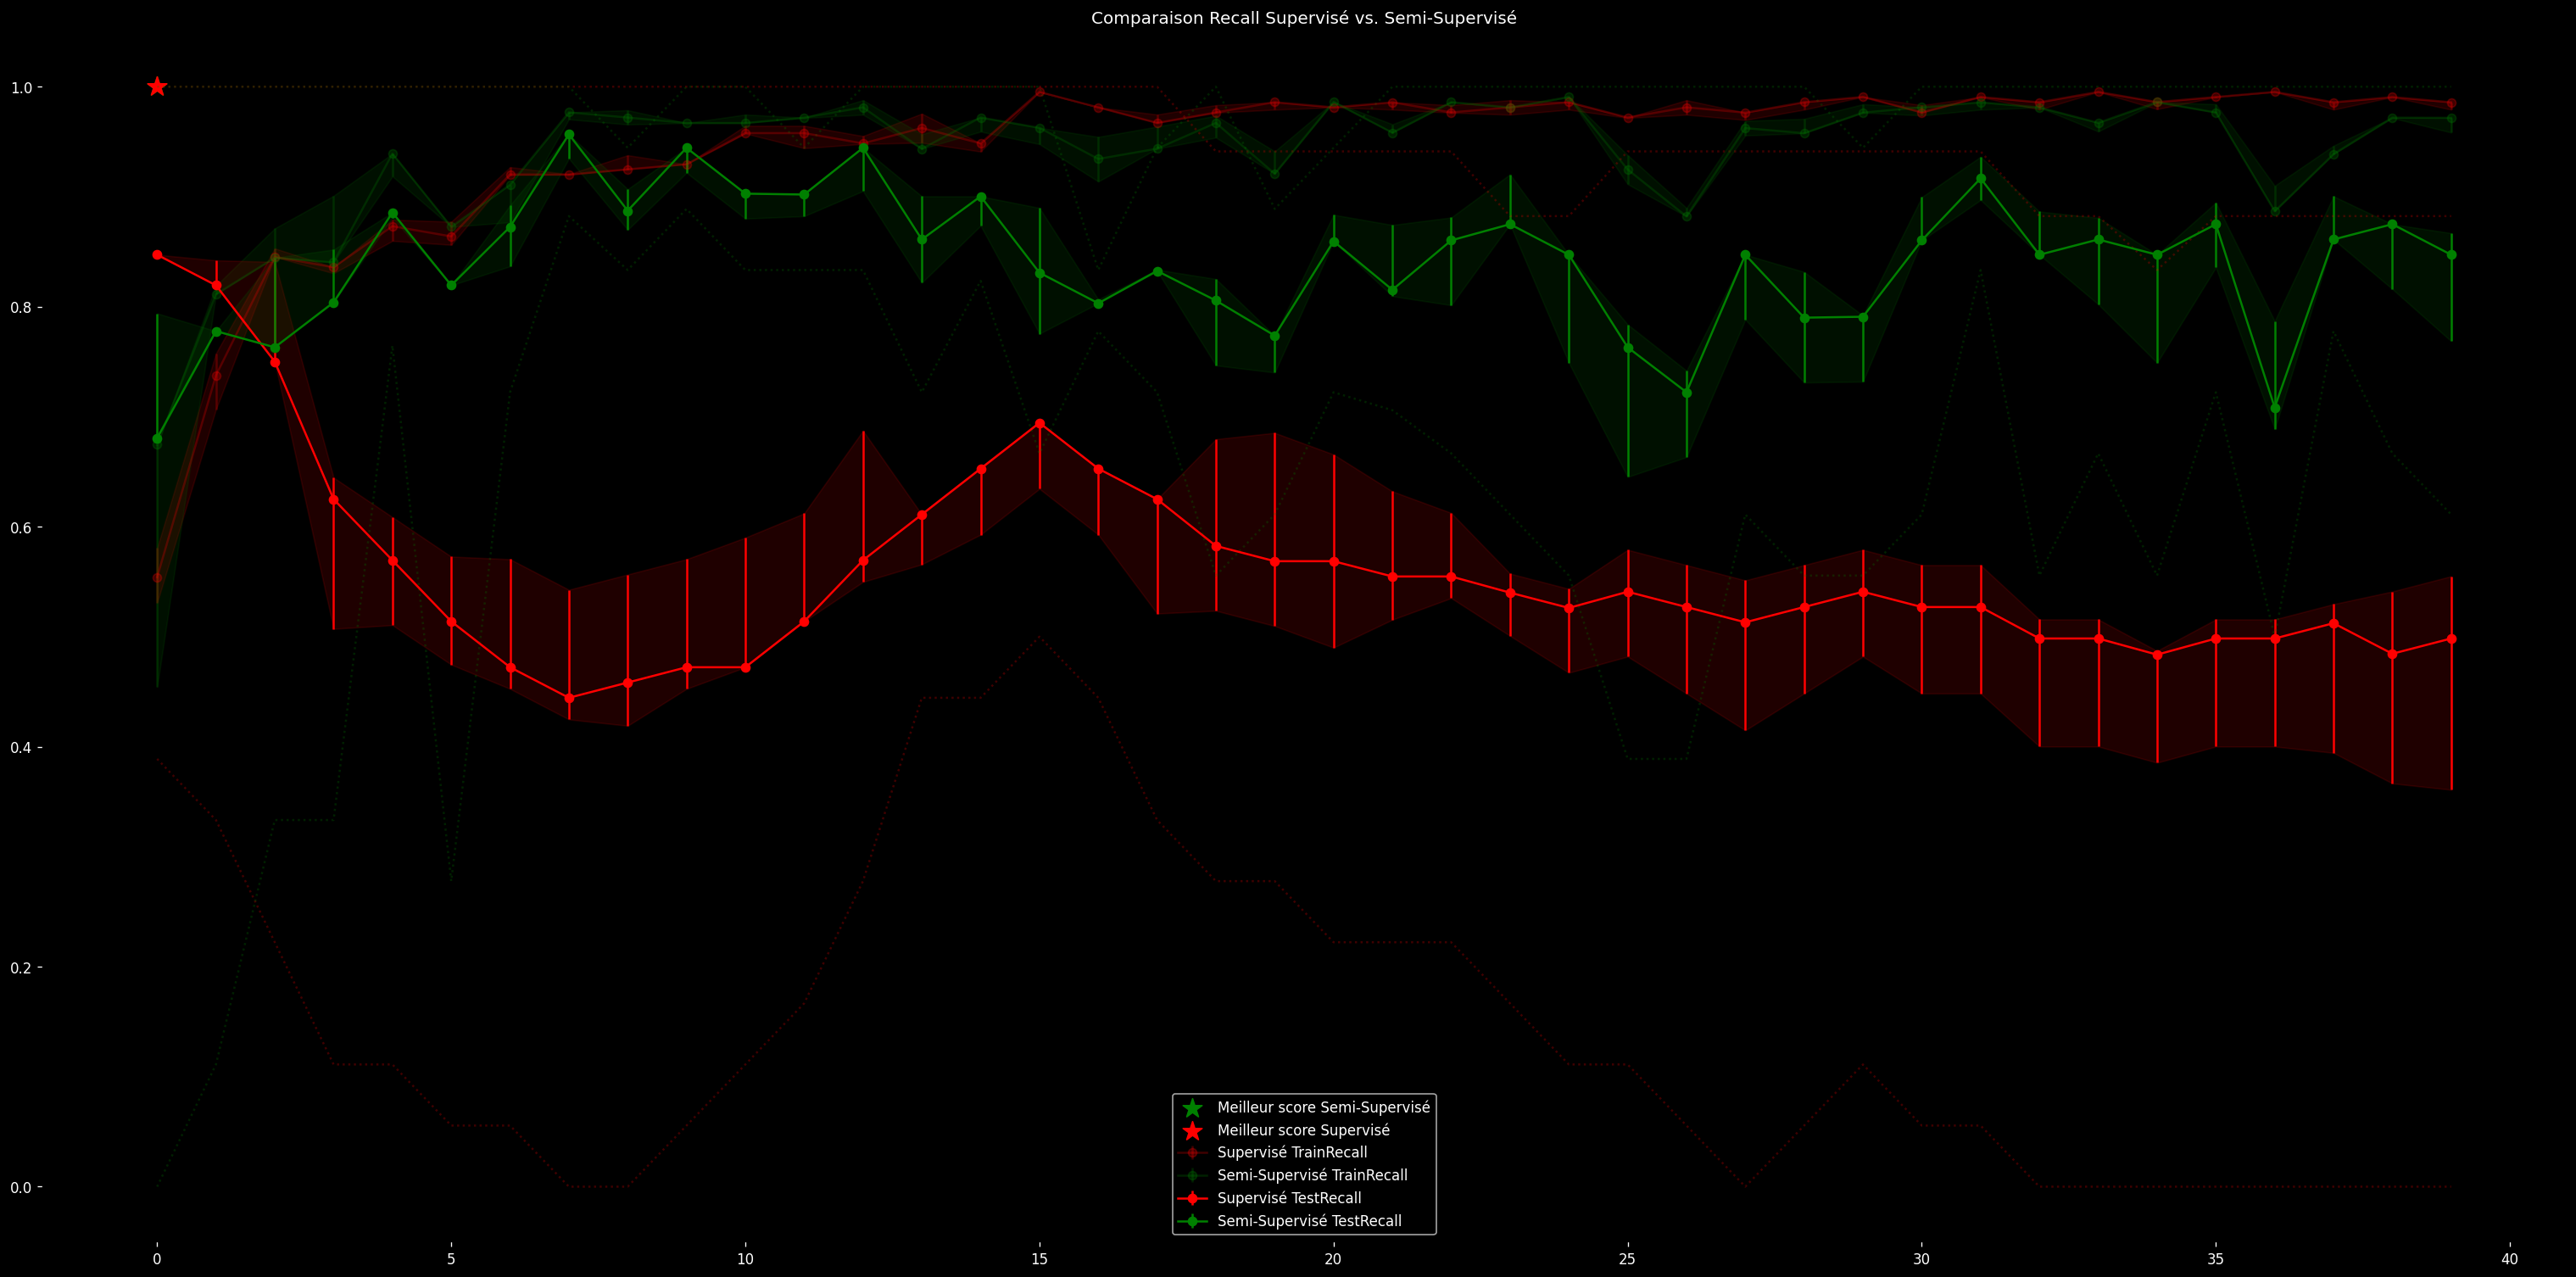

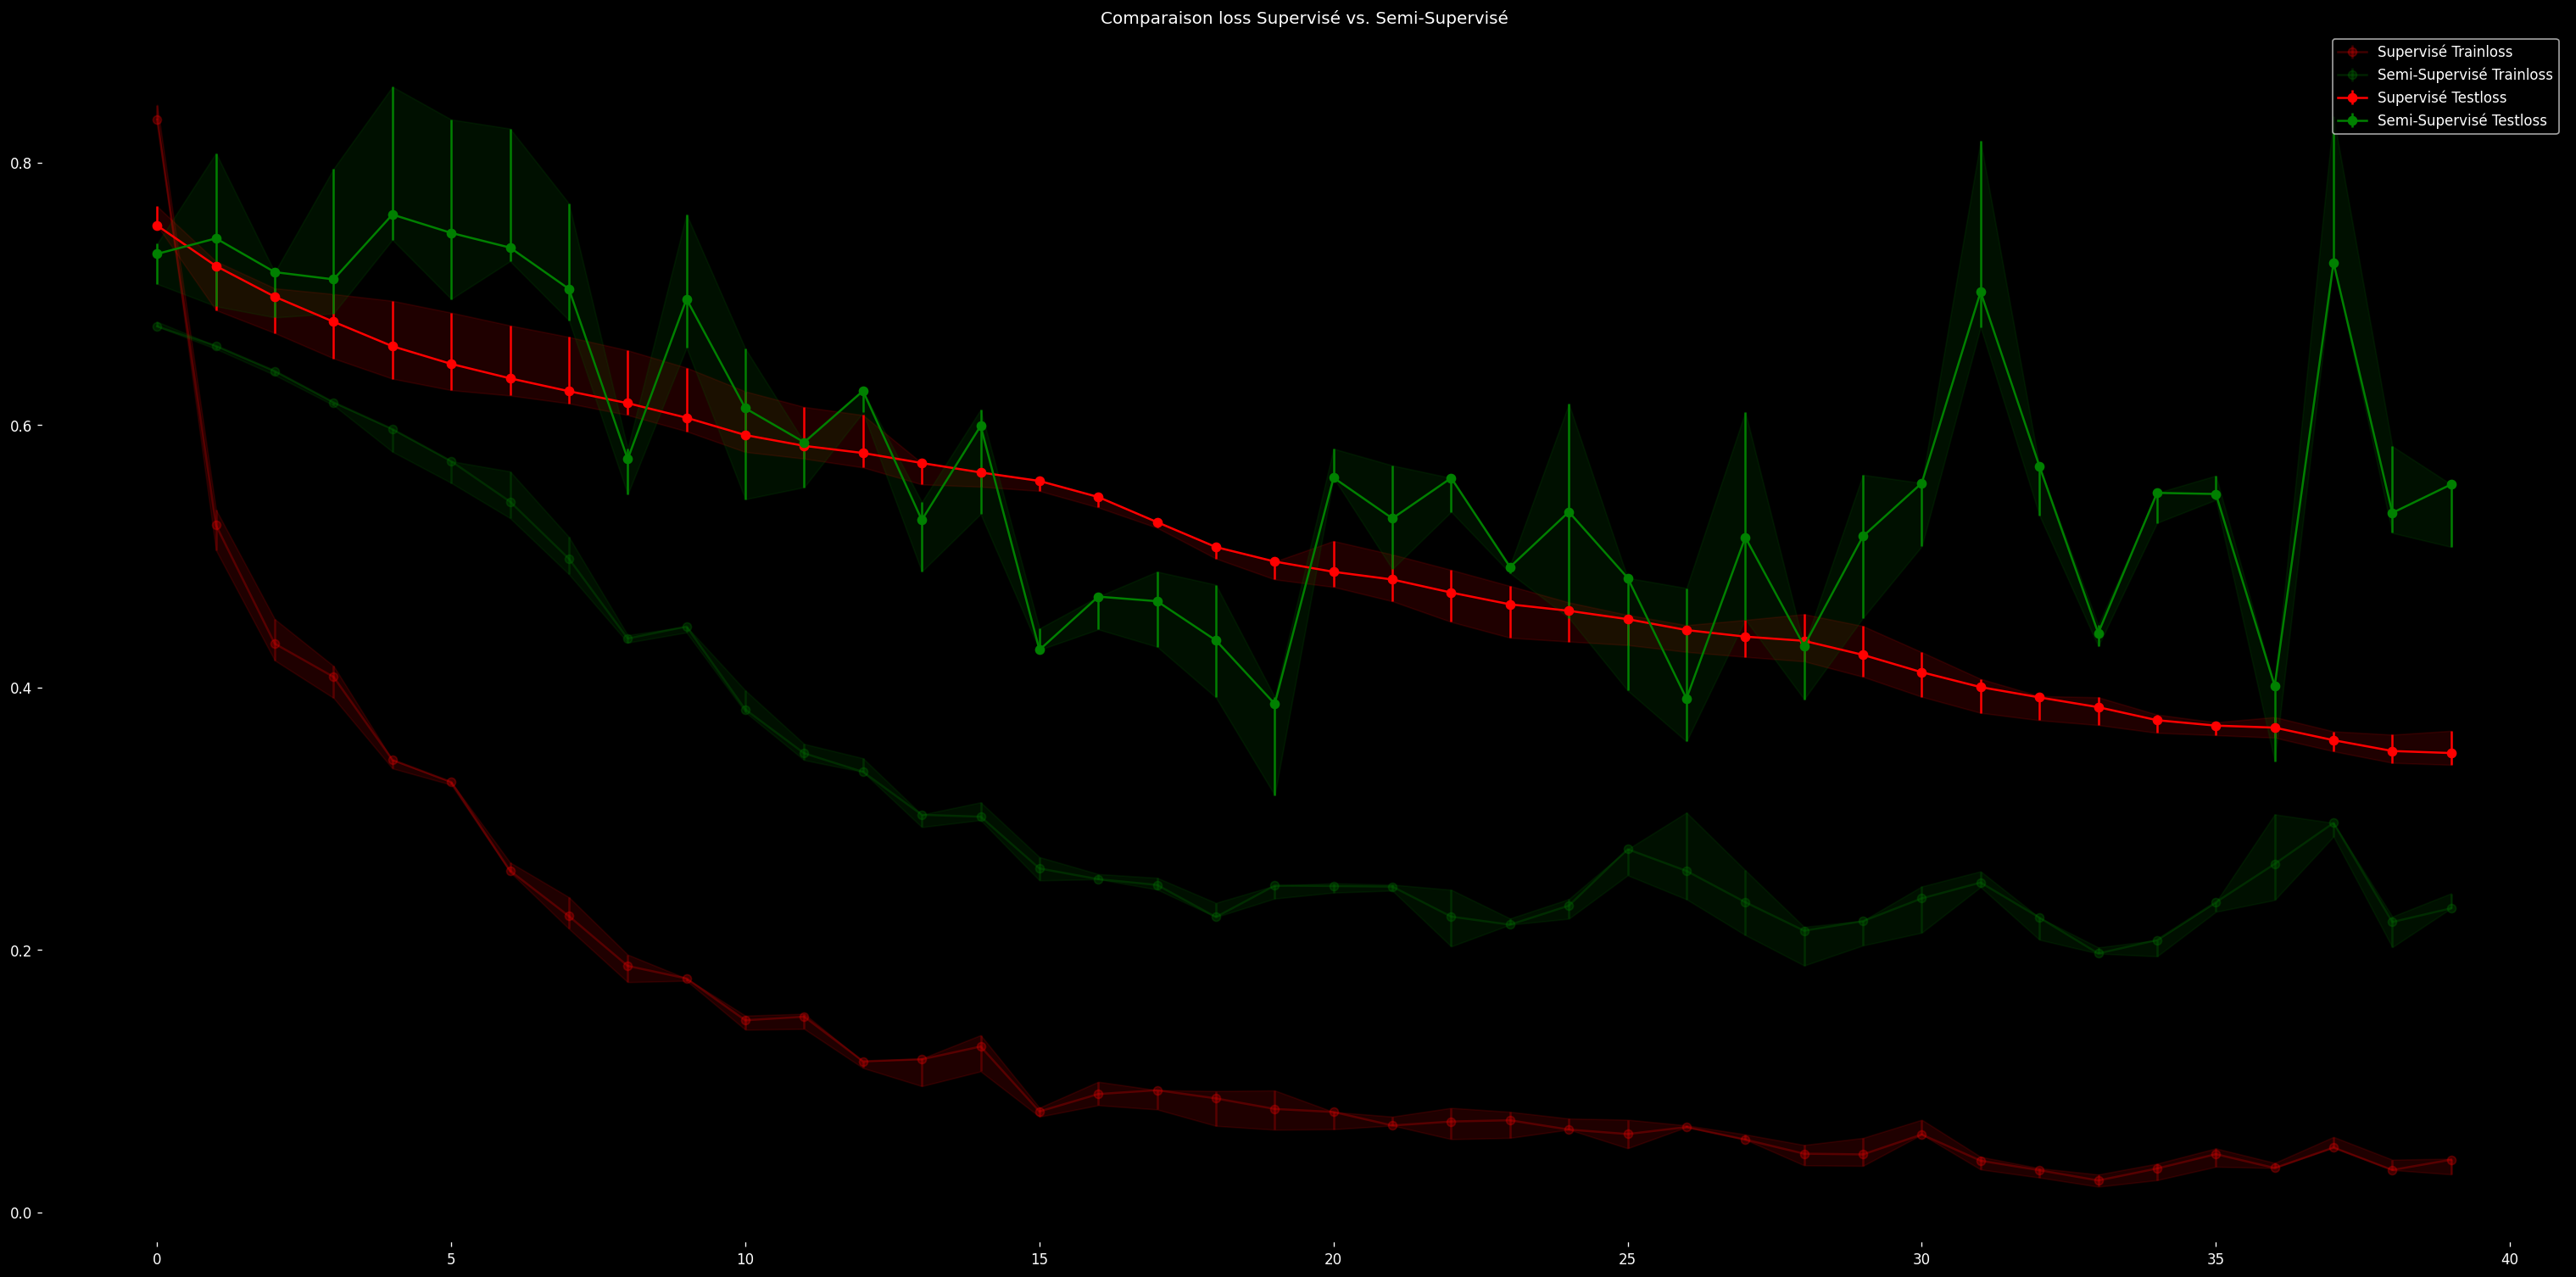

In [91]:
errorbar = True
fill_between = True
display_train = True
plot_resume("APS", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("AUC", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Precision", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Recall", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("loss", errorbar=errorbar, fill_between=fill_between, display_train=True, plot_max=False)

In [40]:
# np.save("training_ss_hist", training_ss_hist)
# np.save("hist_supervise", hist_supervise)

In [41]:
# training_ss_hist = np.load("training_ss_hist.npy", allow_pickle=True)
# hist_supervise = np.load("hist_supervise.npy", allow_pickle=True)

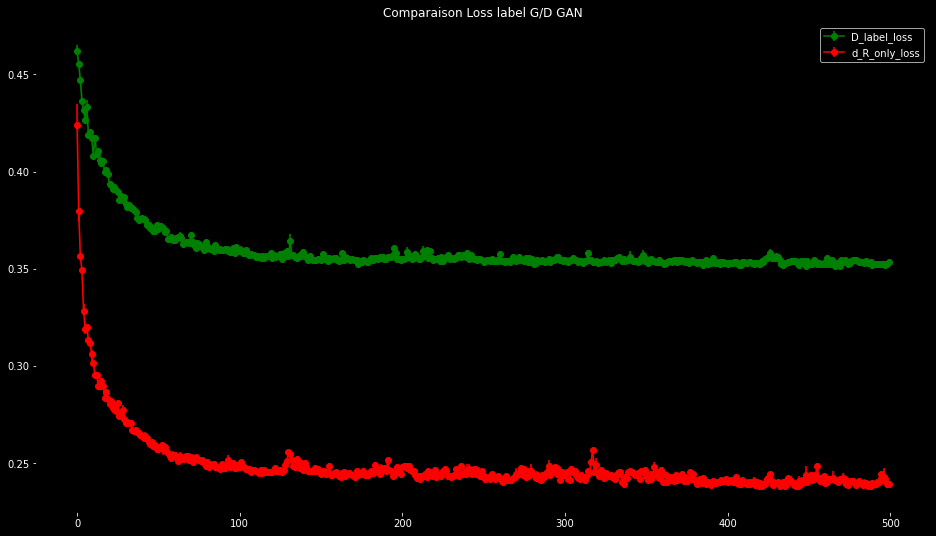

In [61]:
G_color, D_color = "red", "green"

D_loss = np.array([hs["D_reality_loss"] for hs in training_ss_hist])
G_loss = np.array([hs["d_R_only_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D_label_loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="d_R_only_loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss label G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

In [58]:
training_ss_hist[0].keys()

dict_keys(['D_loss', 'd_R_only_loss', 'D_label_loss', 'D_reality_loss', 'G_loss', 'G_label_loss', 'G_reality_loss', 'loss', 'Precision', 'Recall', 'AUC', 'APS', 'val_loss', 'val_Precision', 'val_Recall', 'val_AUC', 'val_APS'])

In [ ]:


# thresholds = 0.5 # limite pour l'arrondissement

# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_score = D_lonly.predict(sup_test[:,1:]).reshape(-1, )
# y_pred = np.where(y_pred_score > thresholds, 1, 0)

# print(np.unique(y_true, return_counts=True))
# print(np.unique(y_pred, return_counts=True))
# """
# Matrice de confusion  | Pred 0 | Pred 1 | Total
# 			Réalité 0 |   VN   |   FP   | de non observation dans la base
# 			Réalité 1 |   FN   |   VP   | d'observation dans la base
# """
# # https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# # Precision
# # = VP / (VP + FP)
# # = VP / P
# # = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# # 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# # Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# # f1 = moyenne harmonique de Precision et Recall

# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Precision: 	{precision}
# Recall: 	{recall}
# f1_score: 	{f1}
# AUC: 		{AUC}
# Matrice de confusion:\n{confusion_matrix}
# """)

# # le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# # si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# # Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# # exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# # on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# # L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)